# Data preprocessing

Importing all libraries required for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pwseqdist as pw
from tcrdist.repertoire import TCRrep
import multiprocessing
from tcrdist.rep_diff import hcluster_diff, member_summ
from hierdiff import plot_hclust_props
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import umap
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

Importing the data into dataframe.

In [2]:
df = pd.read_csv("vdjdb.txt", sep='\t')

Check null values

In [3]:
#df

In [4]:
df= df[['complex.id','gene','cdr3','v.segm','j.segm','species','mhc.class','antigen.species','antigen.epitope','vdjdb.score']]

Rename the columns

In [5]:
df = df.rename(columns={"complex.id": "ComplexID","gene": "Gene","cdr3": "CDR3", "v.segm": "V","j.segm": "J","species": "Species","mhc.class": "MHCclass"
                  ,"antigen.species": "EpitopeSpecies","antigen.epitope": "Epitope","vdjdb.score": "Score"})

In [6]:
len(df)

92771

Check how many records that have zero score.

In [7]:
df_z = df[df['Score'] == 0]

In [8]:
len(df_z)

80357

Only take the records that has score not equal to zero.

In [9]:
df = df[df['Score'] != 0]

In [10]:
len(df)

12414

Check null values.

In [11]:
df.isnull().sum()

ComplexID           0
Gene                0
CDR3                0
V                  28
J                 258
Species             0
MHCclass            0
EpitopeSpecies      0
Epitope             0
Score               0
dtype: int64

In [12]:
nan_values = df[df.isna().any(axis=1)]

#nan_values

Drop null values.

In [13]:
df = df.dropna()
df.isnull().sum()

ComplexID         0
Gene              0
CDR3              0
V                 0
J                 0
Species           0
MHCclass          0
EpitopeSpecies    0
Epitope           0
Score             0
dtype: int64

In [14]:
len(df)

12156

Split the data into 3 subsets using specific columns. So we end up with three species (Human, Mouse, and Monkey).

In [15]:
unique_values = df['Species'].unique()

print(unique_values)

['HomoSapiens' 'MusMusculus' 'MacacaMulatta']


In [16]:
dfh = df[df['Species'] == 'HomoSapiens'] #human
dfm = df[df['Species'] == 'MusMusculus'] #mouse
dfmu = df[df['Species'] == 'MacacaMulatta'] #monkey

In [17]:
len(dfh)

9376

In [18]:
len(dfm)

2121

In [19]:
len(dfmu)

659

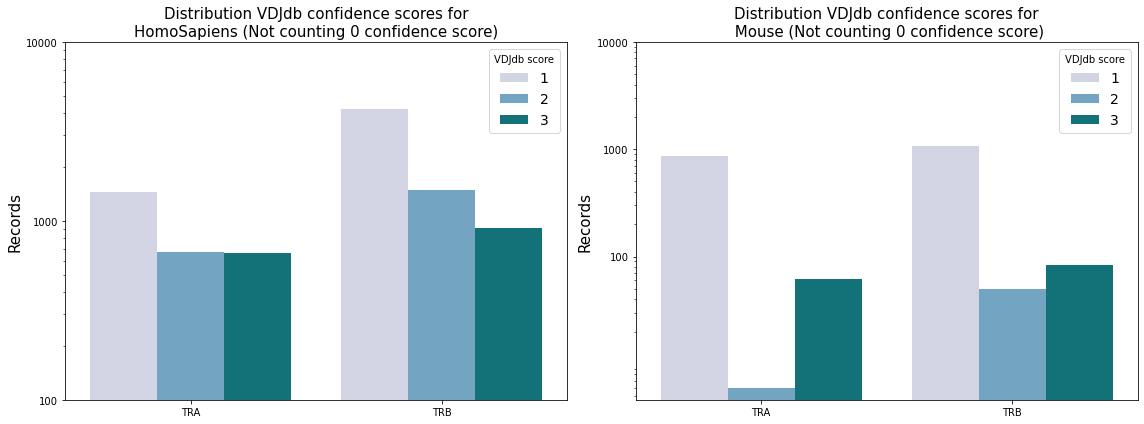

In [20]:
df_human = dfh.groupby(['Gene', 'Score']).size().reset_index(name='total')
df_mouse = dfm.groupby(['Gene', 'Score']).size().reset_index(name='total')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_human, x='Gene', y='total', hue='Score', dodge=True, palette="PuBuGn", ax=axs[0])
axs[0].set_xlabel('')  
axs[0].set_ylabel('Records', fontsize=15)  
axs[0].set_yscale('log')
axs[0].legend(title='VDJdb score', loc='upper right',fontsize=14)
axs[0].set_title('Distribution VDJdb confidence scores for\nHomoSapiens (Not counting 0 confidence score)', fontsize=15)  # Set title font size

ticks = [100, 1000, 10000]
axs[0].set_yticks(ticks)
axs[0].set_yticklabels([f'{tick}' for tick in ticks])

sns.barplot(data=df_mouse, x='Gene', y='total', hue='Score', dodge=True, palette="PuBuGn", ax=axs[1])
axs[1].set_xlabel('')  
axs[1].set_ylabel('Records', fontsize=15)  
axs[1].set_yscale('log')
axs[1].legend(title='VDJdb score', loc='upper right',fontsize=14)
axs[1].set_title('Distribution VDJdb confidence scores for\n Mouse (Not counting 0 confidence score)', fontsize=15)  # Set title font size

axs[1].set_yticks(ticks)
axs[1].set_yticklabels([f'{tick}' for tick in ticks])

plt.tight_layout()
plt.show()


# Mouse Data Cleaning and Mesuring the distance.

In [21]:
dfm = dfm.dropna()

In [22]:
len(dfm)

2121

Split the mouse data frame into two sub-data frames. The first one contains the CDR3_alpha sequences and all affiliated data from other columns. The second one contains CDR3_beta sequences and all the associated data from other columns.

In [23]:
dfm_alpha = dfm[dfm['Gene'] == 'TRA']
dfm_beta = dfm[dfm['Gene'] == 'TRB']

In [24]:
dfm_alpha.reset_index(drop=True, inplace=True)
dfm_beta.reset_index(drop=True, inplace=True)

In [25]:
#dfm_alpha # TCRs of alpha chain mouse

In [26]:
len(dfm_beta)

1194

In [27]:
len(dfm_alpha)

927

In [28]:
#dfm_alpha

In [29]:
#dfm_beta

# Mesure the distance for alpha and beta data frames (Mouse):

To measure the distance we only need the following columns (ComplexID, CDR3,V, J, and optionally Epitope). We also kept EpitopeSpecies column for further plotting (The aim is to plot the TCRs clusters and color them in terms of EpitopeSpecies)

In [30]:
dfm_alpha_distance = dfm_alpha.drop(columns=['Gene','Species','MHCclass','Score'])
dfm_beta_distance = dfm_beta.drop(columns=['Gene','Species','MHCclass','Score'])
dfm_alpha_distance = dfm_alpha_distance.dropna()
dfm_beta_distance = dfm_beta_distance.dropna()

In [31]:
dfm_alpha_distance.isnull().values.any()

False

In [32]:
dfm_beta_distance.isnull().values.any()

False

Check duplicated rows

In [33]:
num_duplicated_rows = dfm_alpha_distance.duplicated().sum()
num_duplicated_rows

0

In [34]:
num_duplicated_rows = dfm_beta_distance.duplicated().sum()
num_duplicated_rows

140

TCRDist3 uses a special naming for colmuns to mesure the distance. So we need to rename the colmuns in way that can be interpreated by algorthim.

In [35]:
dfm_alpha_distance = dfm_alpha_distance.rename(columns={'CDR3': 'cdr3_a_aa', 'V': 'v_a_gene', 'J': 'j_a_gene','Epitope': 'epitope'})
dfm_beta_distance = dfm_beta_distance.rename(columns={'CDR3': 'cdr3_b_aa', 'V': 'v_b_gene', 'J': 'j_b_gene','Epitope': 'epitope'})

In [36]:
len(dfm_beta_distance)

1194

Adding count columns to the data frame. (PS: We need to keep the ComplexID column because it helps us prevent grouping two identical rows from two different donors into one row which will simply have a consequence when comes to calculating the distance. 

In [37]:
dfm_alpha_distance = dfm_alpha_distance.groupby(dfm_alpha_distance.columns.tolist()).size().reset_index().rename(columns={0:'count'})

In [38]:
dfm_beta_distance = dfm_beta_distance.groupby(dfm_beta_distance.columns.tolist()).size().reset_index().rename(columns={0:'count'})

In [39]:
#dfm_beta_distance

In [40]:
#dfm_alpha_distance

# Distaince between alpha chains (Mouse)

To find the distance between TCRs we used the TCRdist3 algorithm. For this purpose, we measured the distance using three different
distance matrices. The first one is the default matrix of TCRdist3 which is pwseqdist. The second one is "pw.metrics.nw_hamming_metric"
a pairwise Needleman-Wunsch alignment followed by hamming distance. And the third one is "pw.metrics.nw_metric" a reciprocal Needleman-Wunsch alignment score-based dissimilarity using BLOSUM62

In [41]:
#Defult matrix "pwseqdist", this distance include also alpha chains that has no beta chains countrypart (complexID = 0)
tr_mouse_alpha_pwseqdist = TCRrep(cell_df = dfm_alpha_distance, 
            organism = 'mouse', 
            chains = ['alpha'], 
            compute_distances = True,
            db_file = 'alphabeta_gammadelta_db.tsv')

trm_alpha_pwseqdist = tr_mouse_alpha_pwseqdist.pw_alpha
trm_alpha_pwseqdist

array([[  0,  90, 128, ..., 128, 130,  98],
       [ 90,   0, 128, ..., 128, 145, 119],
       [128, 128,   0, ..., 107, 142, 161],
       ...,
       [128, 128, 107, ...,   0, 144, 158],
       [130, 145, 142, ..., 144,   0, 164],
       [ 98, 119, 161, ..., 158, 164,   0]], dtype=int16)

In [42]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric, this distance include also alpha chains that has
#no beta chains countrypart (complexID = 0)

metrics = [pw.metrics.nw_hamming_metric,pw.metrics.nw_metric]
for metric in metrics:
    tr = TCRrep(cell_df = dfm_alpha_distance, 
                organism = 'mouse', 
                chains = ['alpha'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')

    metrics_a = {
        "cdr3_a_aa" : metric,
        "pmhc_a_aa" : metric,
        "cdr2_a_aa" : metric,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric,
        "pmhc_b_aa" : metric,
        "cdr2_b_aa" : metric,
        "cdr1_b_aa" : metric}

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }
    
    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    if metric == pw.metrics.nw_hamming_metric:
        trm_alpha_hamming_metric = tr.pw_alpha
        trm_alpha_hamming_metric
    else:
        trm_alpha_nw_metric = tr.pw_alpha
        trm_alpha_nw_metric
            

# Distaince between beta chain (Mouse)

In [43]:
##Defult matrix "pwseqdist" , this distance include beta chains that has no alpha chains countrypart (complexID = 0)
tr_mouse_beta_pwseqdist = TCRrep(cell_df = dfm_beta_distance, 
            organism = 'mouse', 
            chains = ['beta'],
            compute_distances = True,
            db_file = 'alphabeta_gammadelta_db.tsv')

trm_beta_pwseqdist = tr_mouse_beta_pwseqdist.pw_beta
trm_beta_pwseqdist

array([[  0,  84,  60, ...,  65, 117, 164],
       [ 84,   0,  48, ..., 104, 153, 173],
       [ 60,  48,   0, ...,  80, 129, 167],
       ...,
       [ 65, 104,  80, ...,   0, 114, 163],
       [117, 153, 129, ..., 114,   0, 127],
       [164, 173, 167, ..., 163, 127,   0]], dtype=int16)

In [44]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric , this distance include also beta chains that has no alpha chains countrypart (complexID = 0)

metrics = [pw.metrics.nw_hamming_metric,pw.metrics.nw_metric]
for metric in metrics:
    tr = TCRrep(cell_df = dfm_beta_distance, 
                organism = 'mouse', 
                chains = ['beta'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')
    metrics_a = {
        "cdr3_a_aa" : metric,
        "pmhc_a_aa" : metric,
        "cdr2_a_aa" : metric,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric,
        "pmhc_b_aa" : metric,
        "cdr2_b_aa" : metric,
        "cdr1_b_aa" : metric}

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }
    
    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    
    if metric == pw.metrics.nw_hamming_metric :
        trm_beta_hamming_metric = tr.pw_beta
        trm_beta_hamming_metric
    else:
        trm_beta_nw_metric = tr.pw_beta
        trm_beta_nw_metric      

# Distance between alpha and beta chains (mouse) "Moving complex.ID 0"

In [45]:
dfm_zero_alpha_complexID = dfm_alpha_distance[dfm_alpha_distance['ComplexID'] == 0]

In [46]:
#len(dfm_zero_alpha_complexID)

In [47]:
dfm_zero_beta_complexID = dfm_beta_distance[dfm_beta_distance['ComplexID'] == 0]

In [48]:
dfm_nonzero_alpha = dfm_alpha_distance[dfm_alpha_distance['ComplexID'] != 0]

In [49]:
dfm_nonzero_beta = dfm_beta_distance[dfm_beta_distance['ComplexID'] != 0]

In [50]:
merged_dfm_nonzero = pd.merge(dfm_nonzero_alpha, dfm_nonzero_beta, on='ComplexID', how='inner')

In [51]:
#len(merged_dfm_nonzero)

In [52]:
merged_dfm_nonzero = merged_dfm_nonzero[['ComplexID','cdr3_a_aa','v_a_gene','j_a_gene','cdr3_b_aa','v_b_gene','j_b_gene','epitope_x','EpitopeSpecies_x']]
merged_dfm_nonzero = merged_dfm_nonzero.groupby(merged_dfm_nonzero.columns.tolist()).size().reset_index().rename(columns={0:'count'})
merged_dfm_nonzero = merged_dfm_nonzero.rename(columns={'epitope_x':'epitope','EpitopeSpecies_x':'EpitopeSpecies'})

In [53]:
#merged_dfm_nonzero

Measuring the distance

In [54]:
tr_mouse_alpha_beta_pwseqdist = TCRrep(cell_df = merged_dfm_nonzero, 
            organism = 'mouse', 
            chains = ['alpha','beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

trm_beta = tr_mouse_alpha_beta_pwseqdist.pw_beta
trm_alpah = tr_mouse_alpha_beta_pwseqdist.pw_alpha
trm_alpha_beta_pwseqdist = trm_beta + trm_alpah
trm_alpha_beta_pwseqdist

array([[  0, 291, 266, ..., 280, 268, 322],
       [291,   0, 317, ..., 295, 313, 352],
       [266, 317,   0, ..., 306, 355, 354],
       ...,
       [280, 295, 306, ...,   0, 258, 321],
       [268, 313, 355, ..., 258,   0, 291],
       [322, 352, 354, ..., 321, 291,   0]], dtype=int16)

In [55]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric, this distance include alpha and beta chains
metrics = [pw.metrics.nw_hamming_metric, pw.metrics.nw_metric]

for metric in metrics:
    tr = TCRrep(cell_df = merged_dfm_nonzero, 
                organism = 'mouse', 
                chains = ['alpha','beta'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')

    metrics_a = {
        "cdr3_a_aa" : metric ,
        "pmhc_a_aa" : metric ,
        "cdr2_a_aa" : metric ,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric ,
        "pmhc_b_aa" : metric ,
        "cdr2_b_aa" : metric ,
        "cdr1_b_aa" : metric  }

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }

    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    if metric == pw.metrics.nw_hamming_metric:
        trm_alpha_hamming_metric_1 = tr.pw_alpha
        trm_beta_hamming_metric_1 = tr.pw_beta
        trm_alpha_beta_hamming_metric = trm_alpha_hamming_metric_1 + trm_beta_hamming_metric_1
    else:
        trm_alpha_nw_metric_1 = tr.pw_alpha
        trm_beta_nw_metric_1 = tr.pw_beta
        trm_alpha_beta_nw_metric = trm_alpha_nw_metric_1 +trm_beta_nw_metric_1

# Clustering Mouse TCRs 

Clustering TCRs alpha chains using TCRdist3 built-in clustring method hcluster_diff.

In [56]:
clone_1_m = tr_mouse_alpha_pwseqdist.clone_df
clone_2_m = tr_mouse_beta_pwseqdist.clone_df
clone_3_m = tr_mouse_alpha_beta_pwseqdist.clone_df

The below block of code is used just to create a hierarchical cluster for each of the pairwise distance metrics used before 
for alpha, beta, and both alpha and beta. Using this code will generate an HTML file showing the cluster interactively.
to use this code you need to pass both the previous distance metrics and previous clones "clone_1_m, clone_2_m, clone_3_m" to output
the cluster as html file.

In [57]:
# pairwise_metrics = [trm_alpha_pwseqdist,trm_alpha_hamming_metric,trm_alpha_nw_metric,
#                    trm_beta_pwseqdist, trm_beta_hamming_metric, trm_beta_nw_metric,
#                    trm_alpha_beta_pwseqdist, trm_alpha_beta_nw_metric, trm_alpha_beta_hamming_metric]
# clone_2_m['SSYRRPVGI'] = ['SSYRRPVGI' if x == 'SSYRRPVGI' else 'All other epitopes' for x in clone_2_m.epitope]
# res, Z= hcluster_diff(clone_2_m, trm_beta_hamming_metric, x_cols = ['SSYRRPVGI'], count_col = 'count')
# res_summary = member_summ(res_df = res, clone_df = clone_2_m, addl_cols=['epitope'])
# res_detailed = pd.concat([res, res_summary], axis = 1)
# html = plot_hclust_props(Z,
#                          title=f'Clustering TCRs mouse beta chains using hamming_metric',
#                          res=res_detailed,
#                          tooltip_cols=['cdr3_b_aa','v_b_gene', 'j_b_gene','epitope'],
#                          alpha=0.00001, colors = ['blue','green'],
#                          alpha_col='pvalue')
# with open('mouse_beta_clustering_using_hamming_metric.html', 'w') as fh:
#     fh.write(html)

# Use UMAP for clustring and plotting:

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.4779250919818878
Davies–Bouldin Index of PwSeqDist: 0.3499752588749476


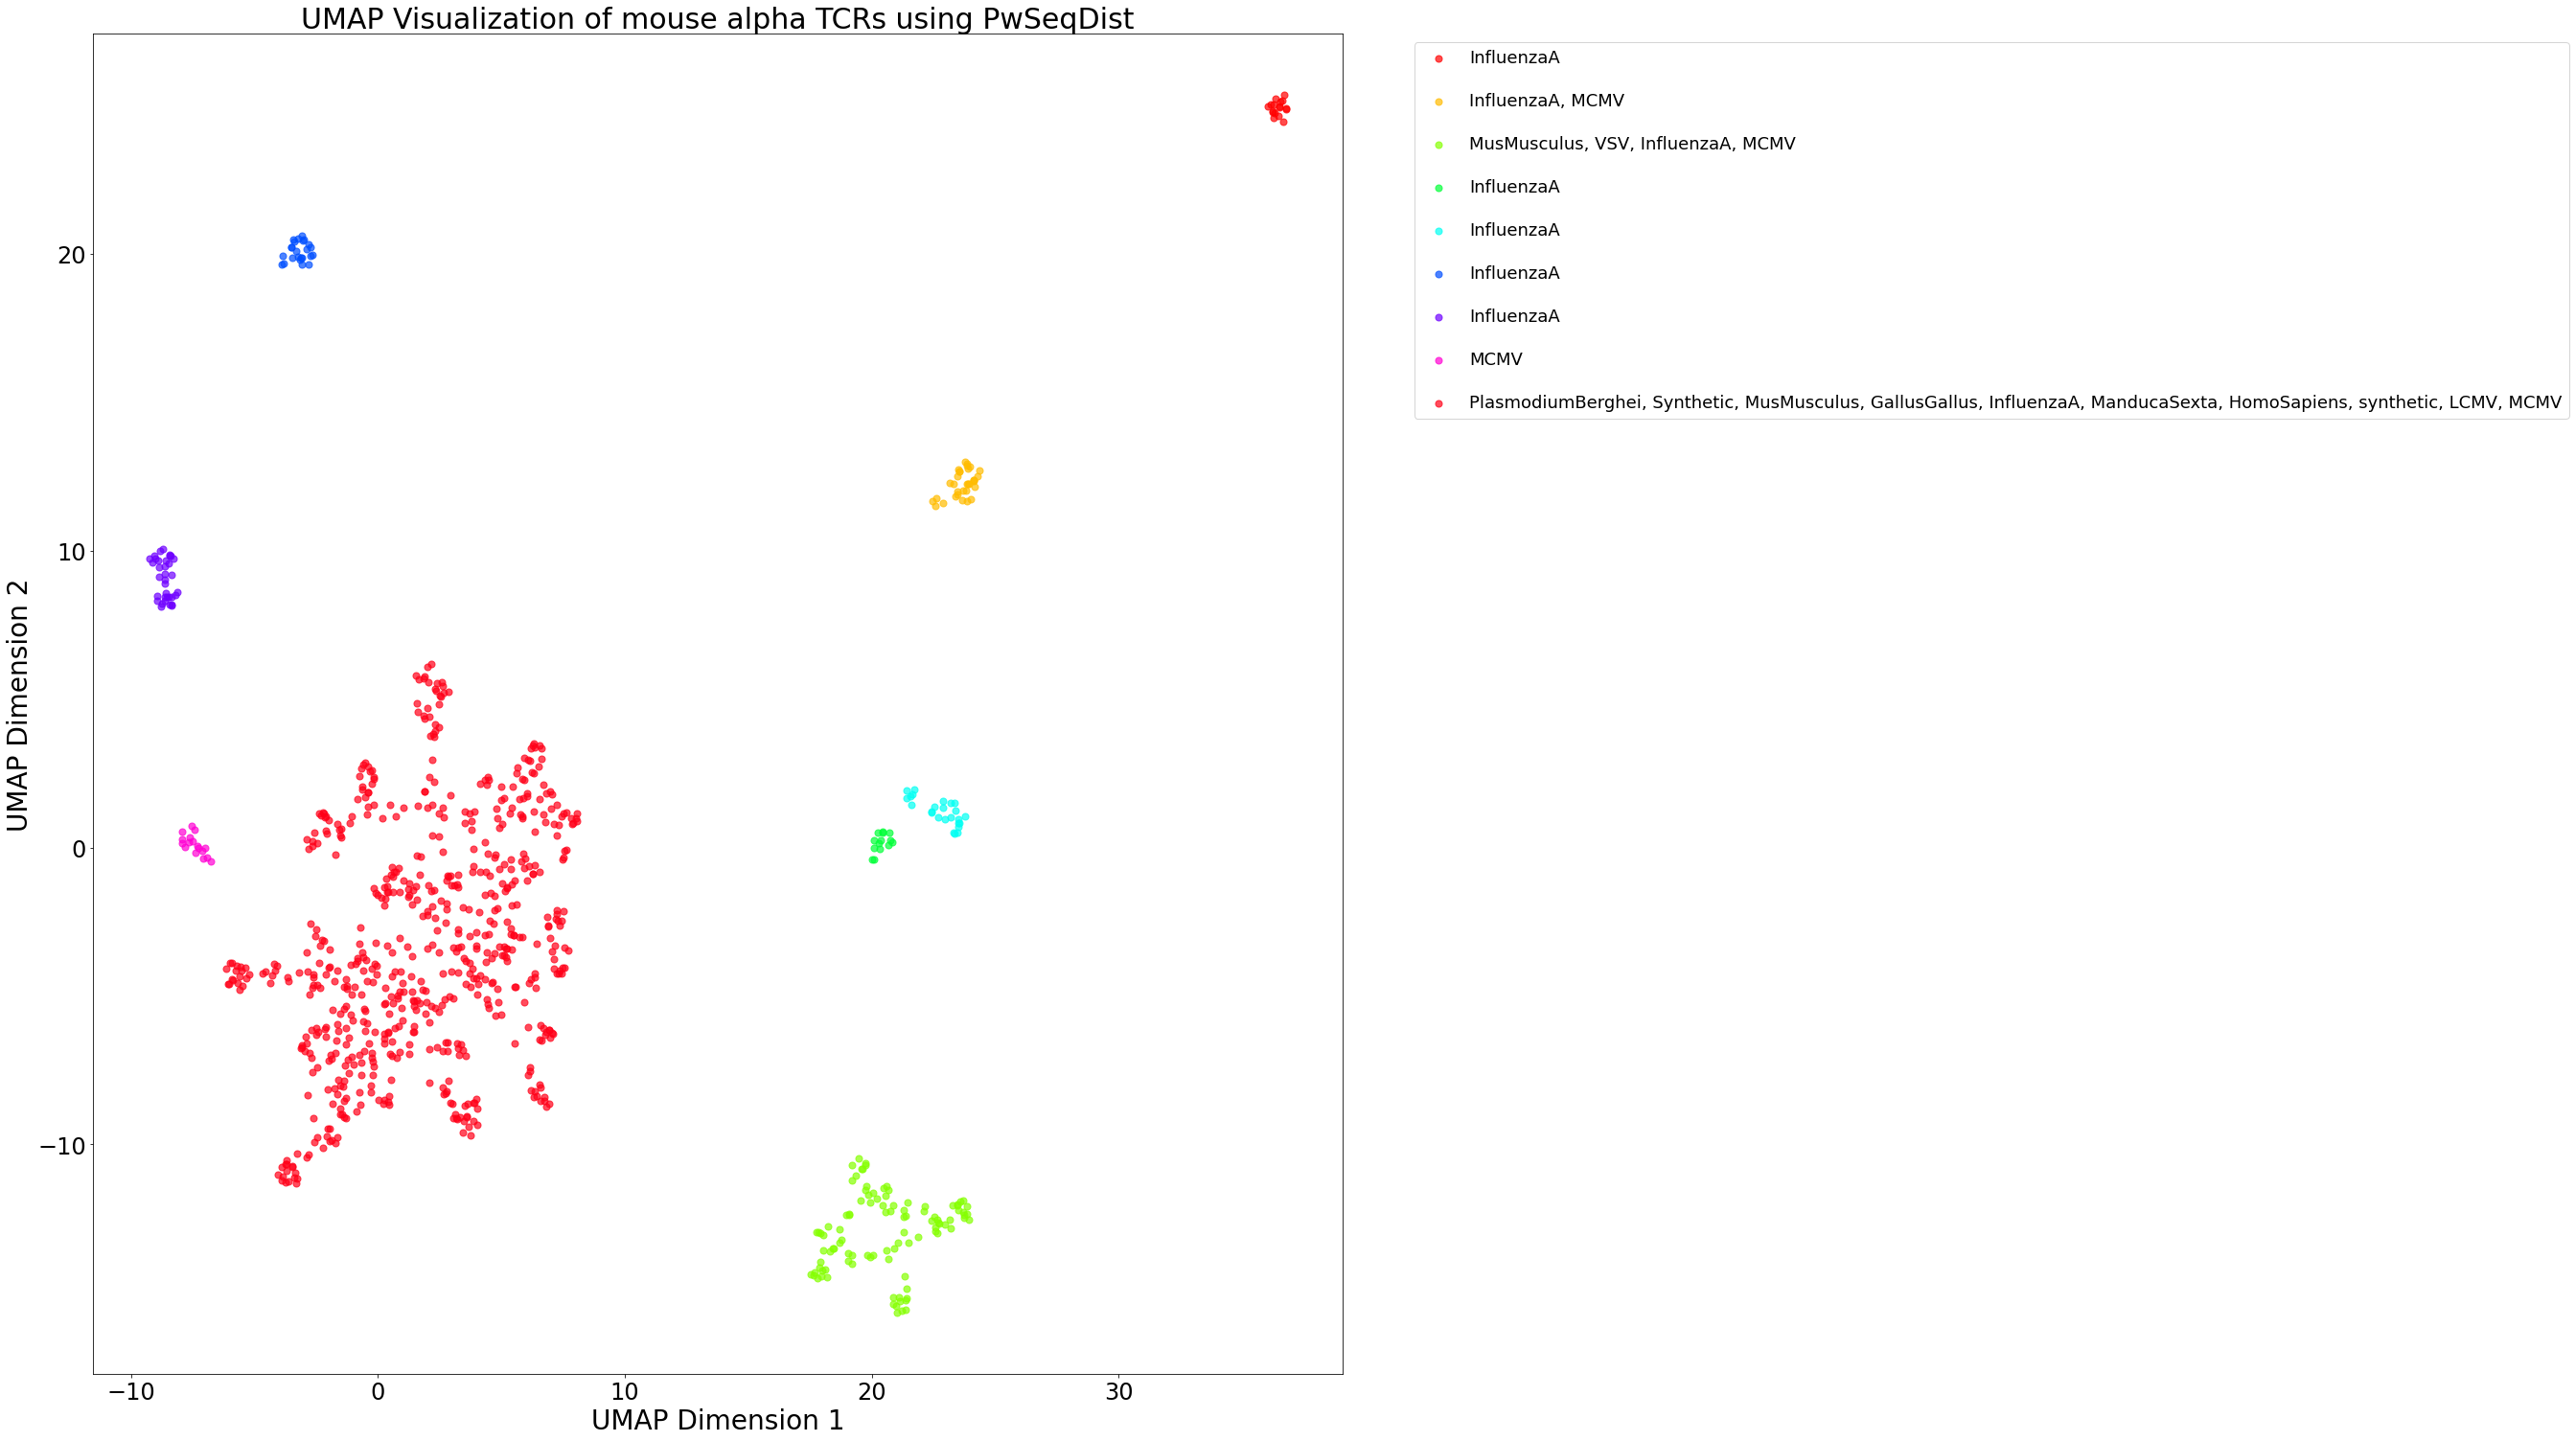

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.6280924677848816
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 1.1550171972580496


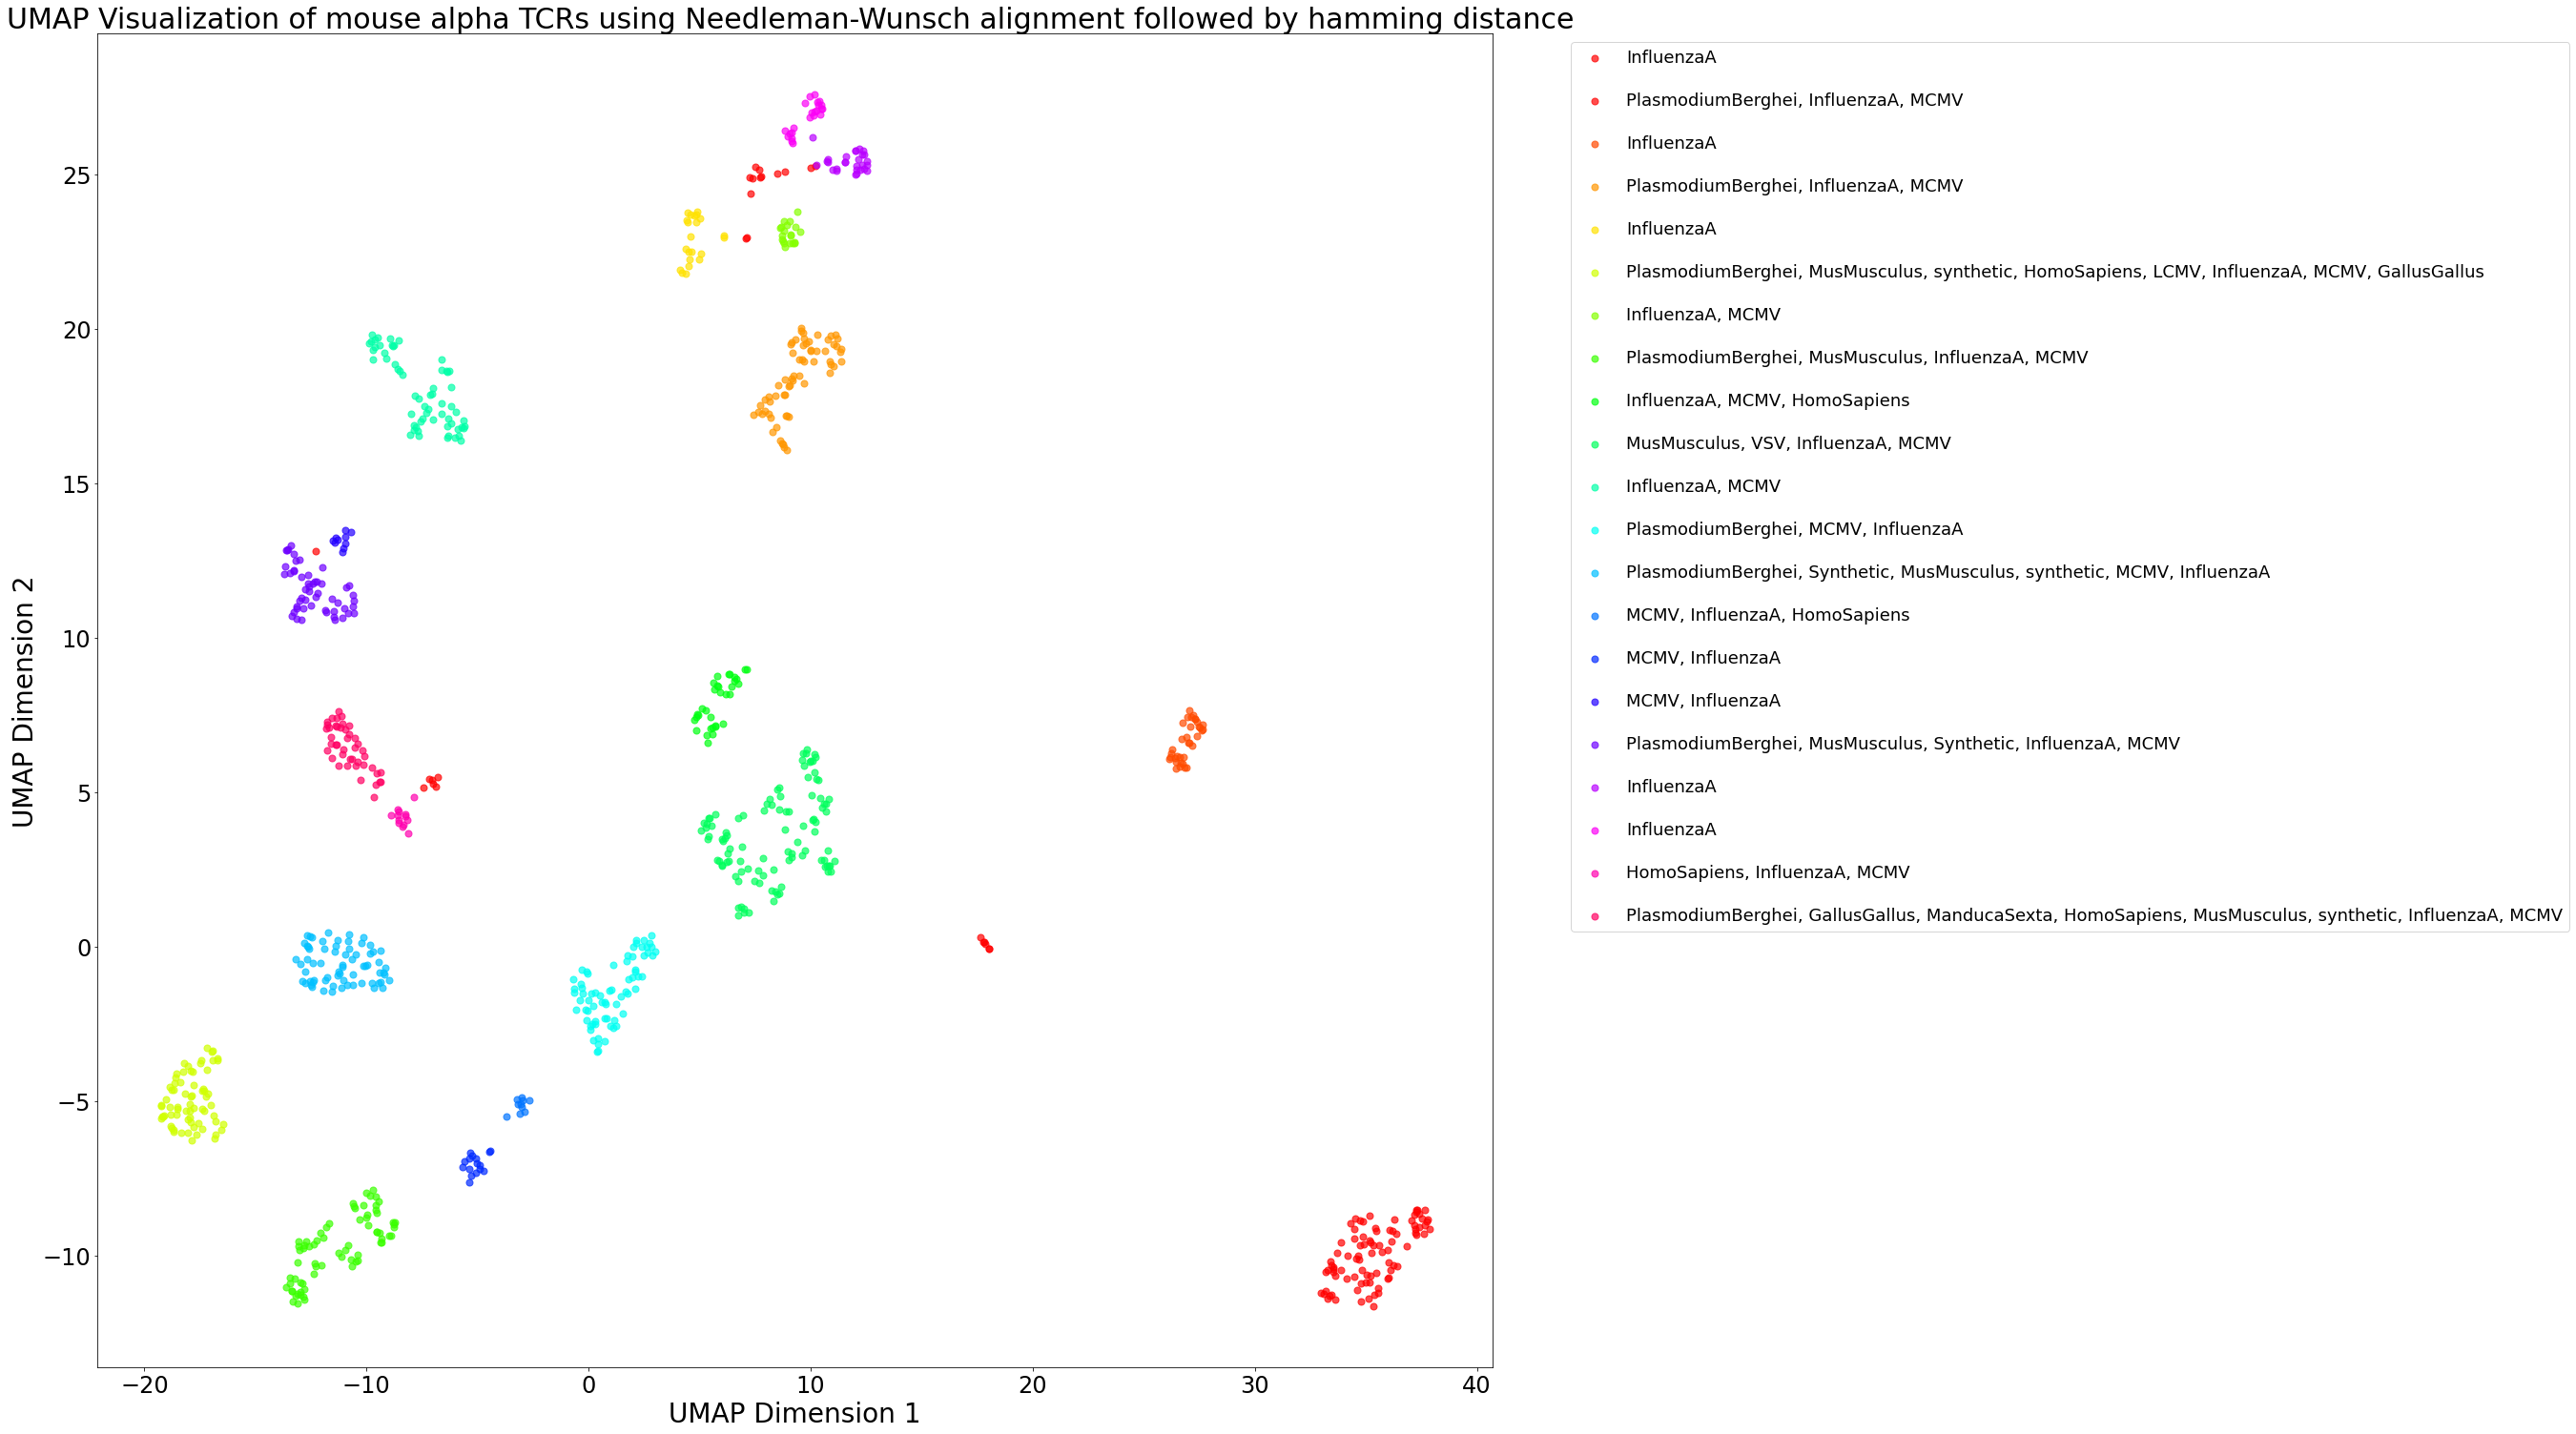

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment score: 0.7027082443237305
Davies–Bouldin Index of Needleman-Wunsch alignment score: 1.1987362937295065


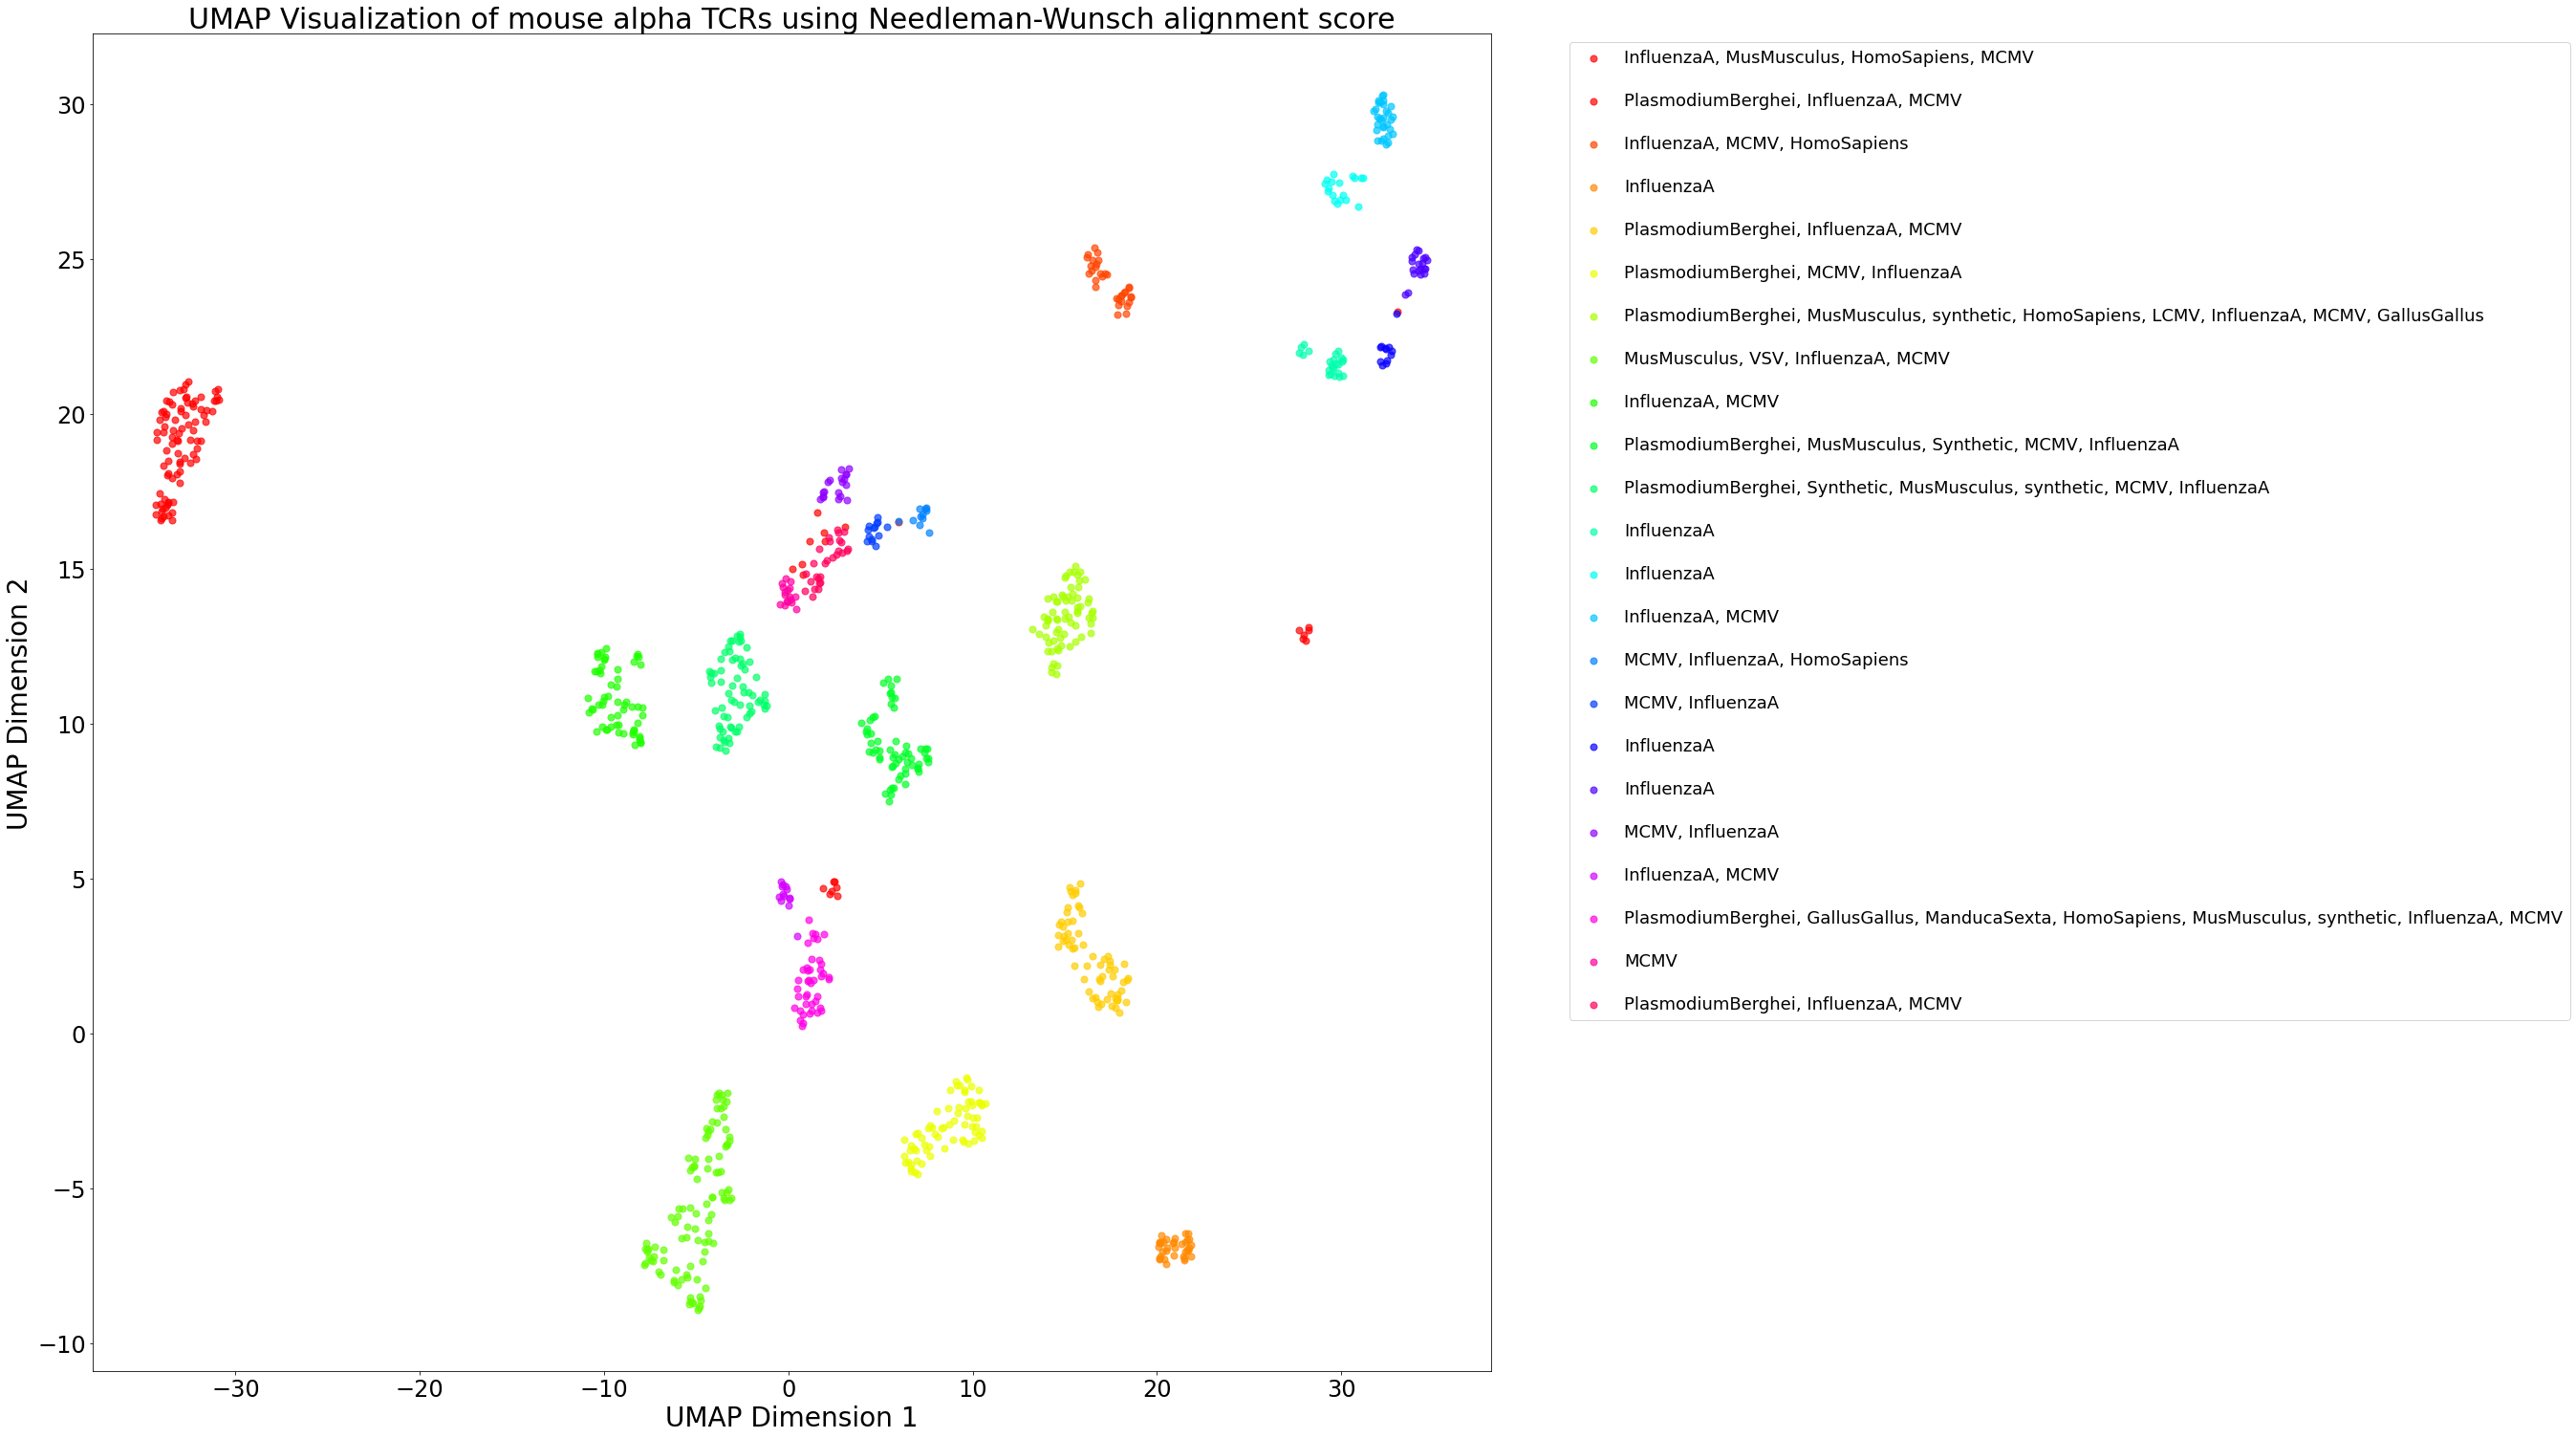

In [112]:
alpha = [trm_alpha_pwseqdist, trm_alpha_hamming_metric, trm_alpha_nw_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for alpha, met_value in zip(alpha, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(alpha)

    labels = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=10).fit_predict(embedding)
    if np.array_equal(alpha, trm_alpha_pwseqdist):
        label_pwseqdist_alpha = labels
    elif np.array_equal(alpha, trm_alpha_hamming_metric):
        label_hamming_metric_alpha = labels
    else:
        label_nw_metric_alpha = labels
    
    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    epitope_names = clone_1_m["EpitopeSpecies"]
    unique_clusters = sorted(set(labels))
    legend_labels = []

    plt.figure(figsize=(38, 21))
    for label in unique_clusters:
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)
        
        cluster_indices = labels == label
        epitope_cluster = epitope_names[cluster_indices]
        epitope_cluster_unique = epitope_cluster.unique()
        legend_labels.append(', '.join(epitope_cluster_unique))
        
    plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1,fontsize='18',labelspacing=1.5)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    plt.title(f'UMAP Visualization of mouse alpha TCRs using {met_value}', fontsize = 30)
    plt.xlabel('UMAP Dimension 1',fontsize = 28)
    plt.ylabel('UMAP Dimension 2',fontsize = 28)
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


Clustering beta chains

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.4290519654750824
Davies–Bouldin Index of PwSeqDist: 0.5356355268242351


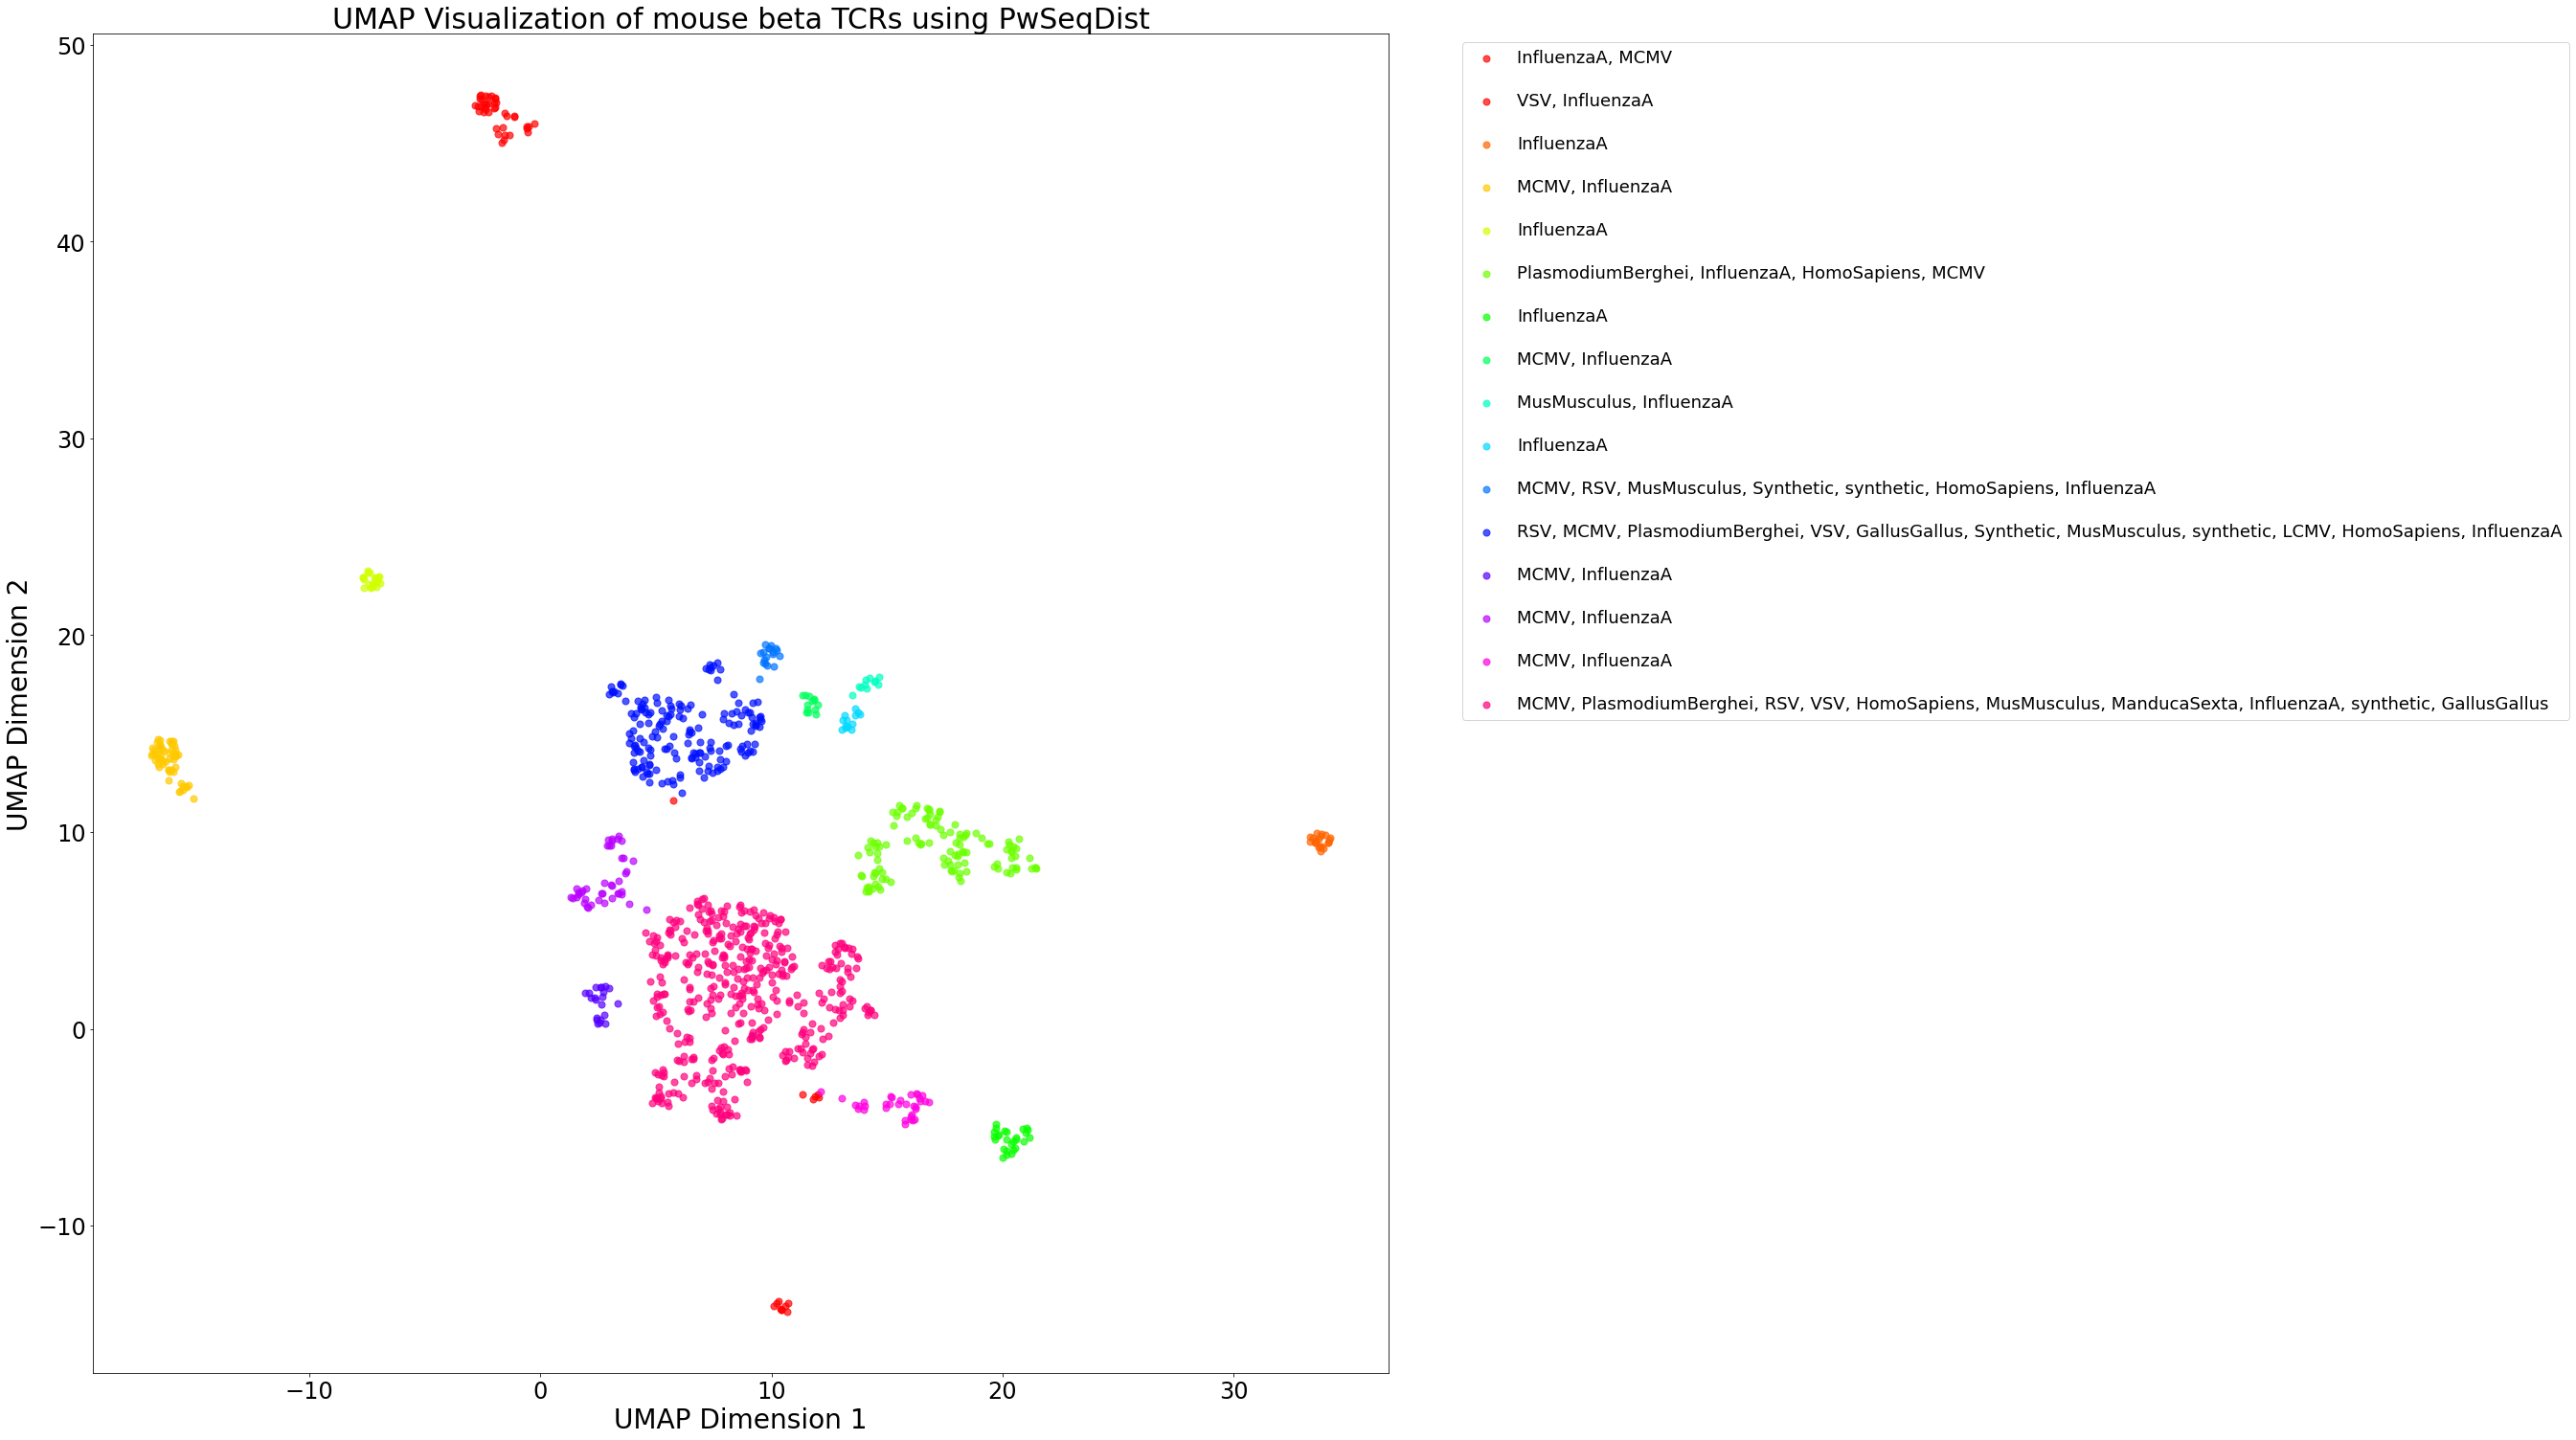

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.6453589797019958
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 0.8720309640696219


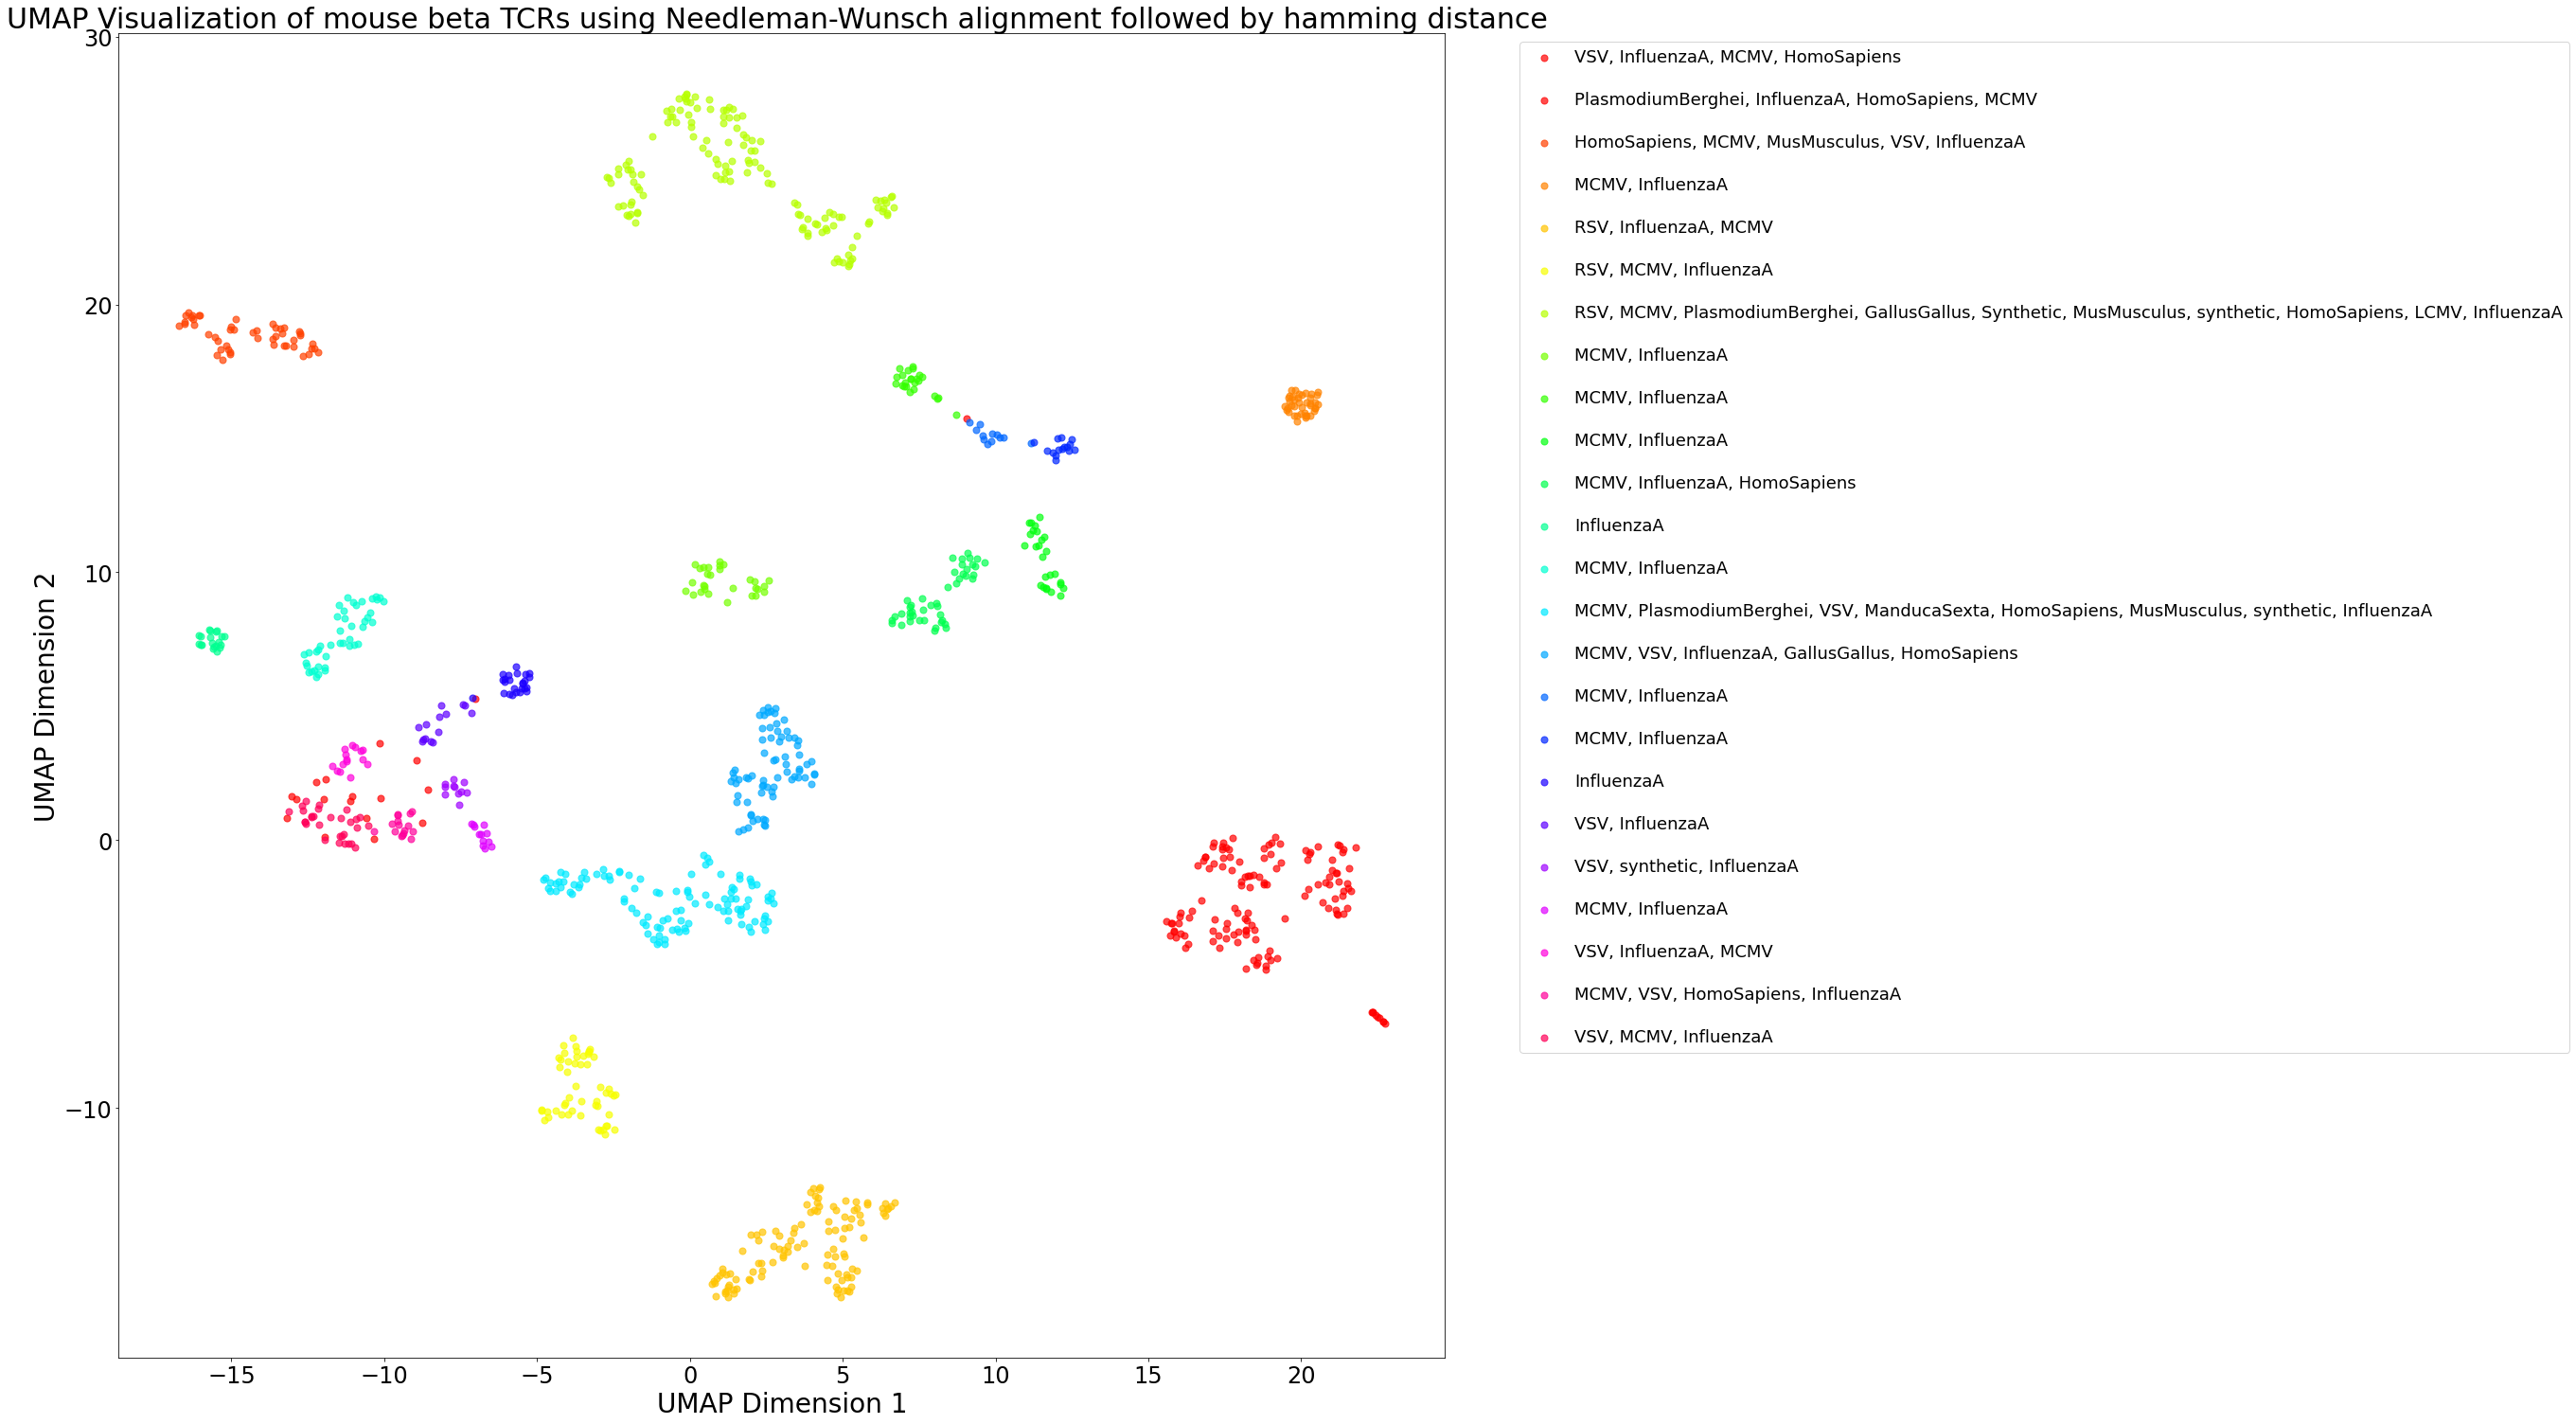

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment score: 0.6605348587036133
Davies–Bouldin Index of Needleman-Wunsch alignment score: 1.1960060558031513


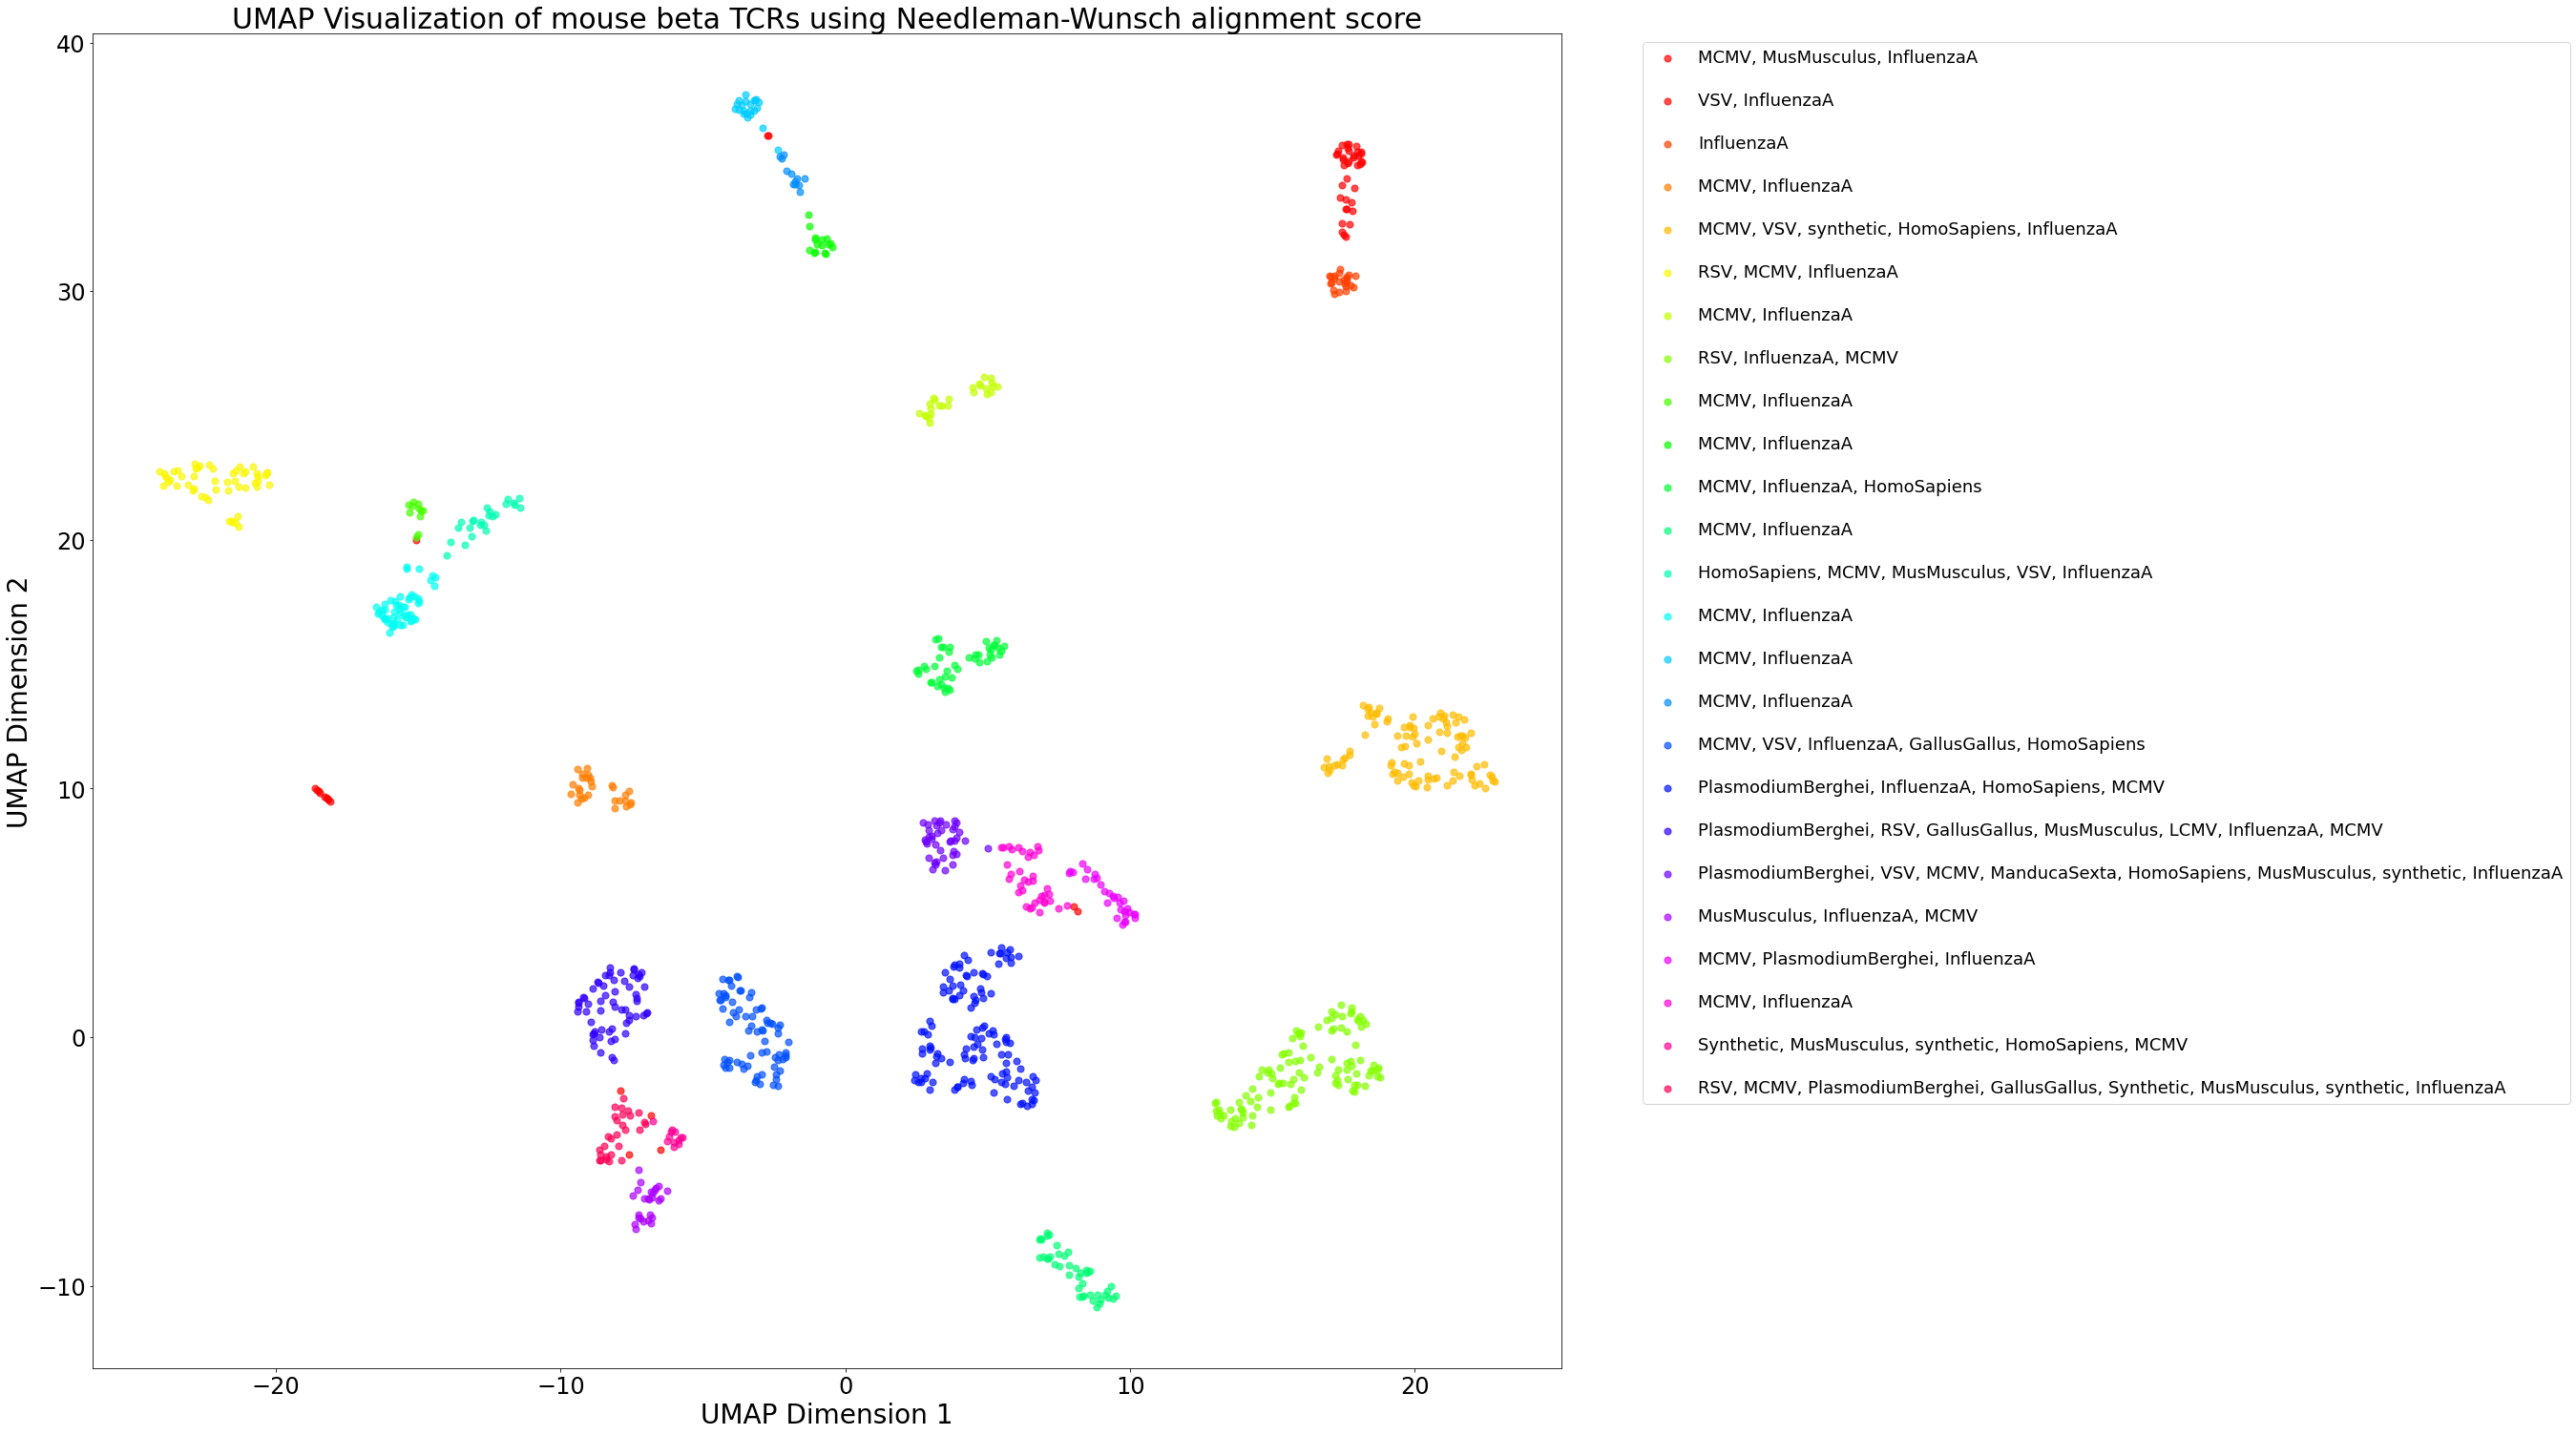

In [113]:
beta = [trm_beta_pwseqdist, trm_beta_hamming_metric, trm_beta_nw_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for beta, met_value in zip(beta, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(beta)

    labels = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=10).fit_predict(embedding)
    if np.array_equal(beta, trm_alpha_pwseqdist):
        label_pwseqdist_beta = labels
    elif np.array_equal(x, trm_alpha_hamming_metric):
        label_hamming_metric_beta = labels
    else:
        label_nw_metric_beta = labels
    
    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    epitope_names = clone_2_m["EpitopeSpecies"]
    unique_clusters = sorted(set(labels))
    legend_labels = []

    plt.figure(figsize=(38, 21))
    for label in unique_clusters:
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)
        
        cluster_indices = labels == label
        epitope_cluster = epitope_names[cluster_indices]
        epitope_cluster_unique = epitope_cluster.unique()
        legend_labels.append(', '.join(epitope_cluster_unique))
        
    plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1,fontsize='18',labelspacing=1.5)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    plt.title(f'UMAP Visualization of mouse beta TCRs using {met_value}',fontsize = 30)
    plt.xlabel('UMAP Dimension 1',fontsize = 28)
    plt.ylabel('UMAP Dimension 2',fontsize = 28)
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


Clustering alpha and beta chains

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.5344431400299072
Davies–Bouldin Index of PwSeqDist: 0.35892072264550245


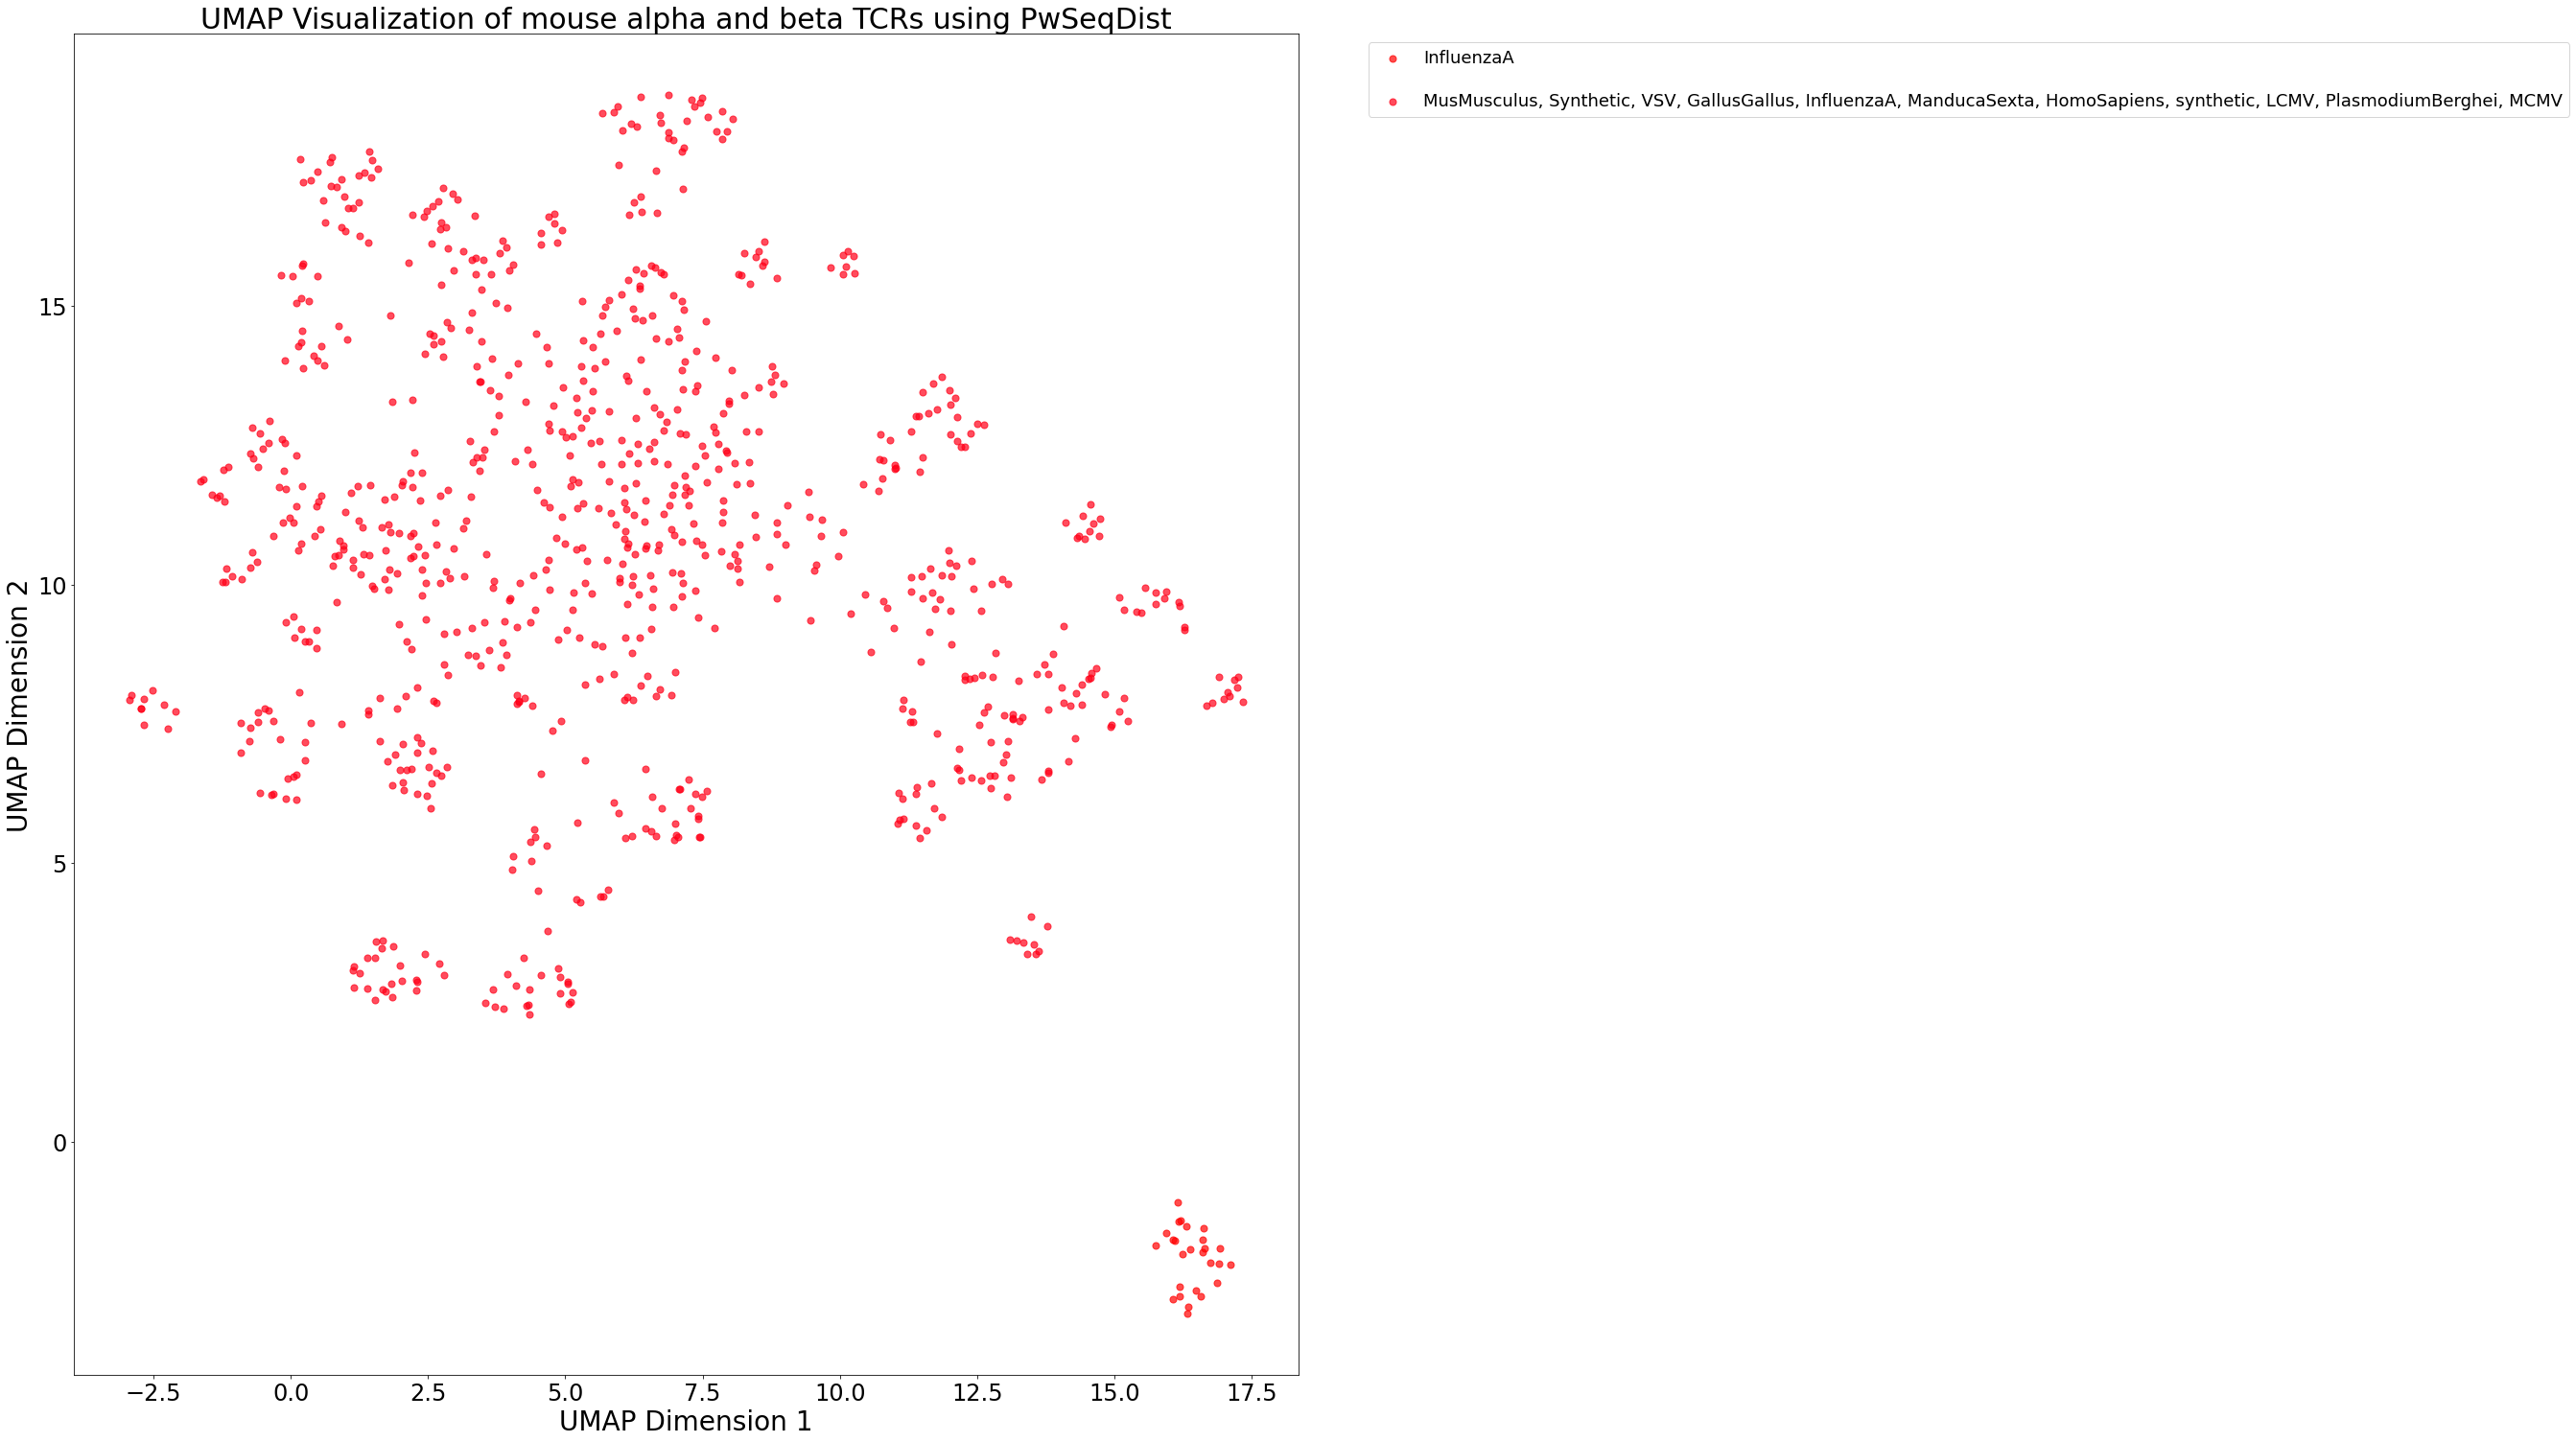

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.5017141103744507
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 1.4167101779628326


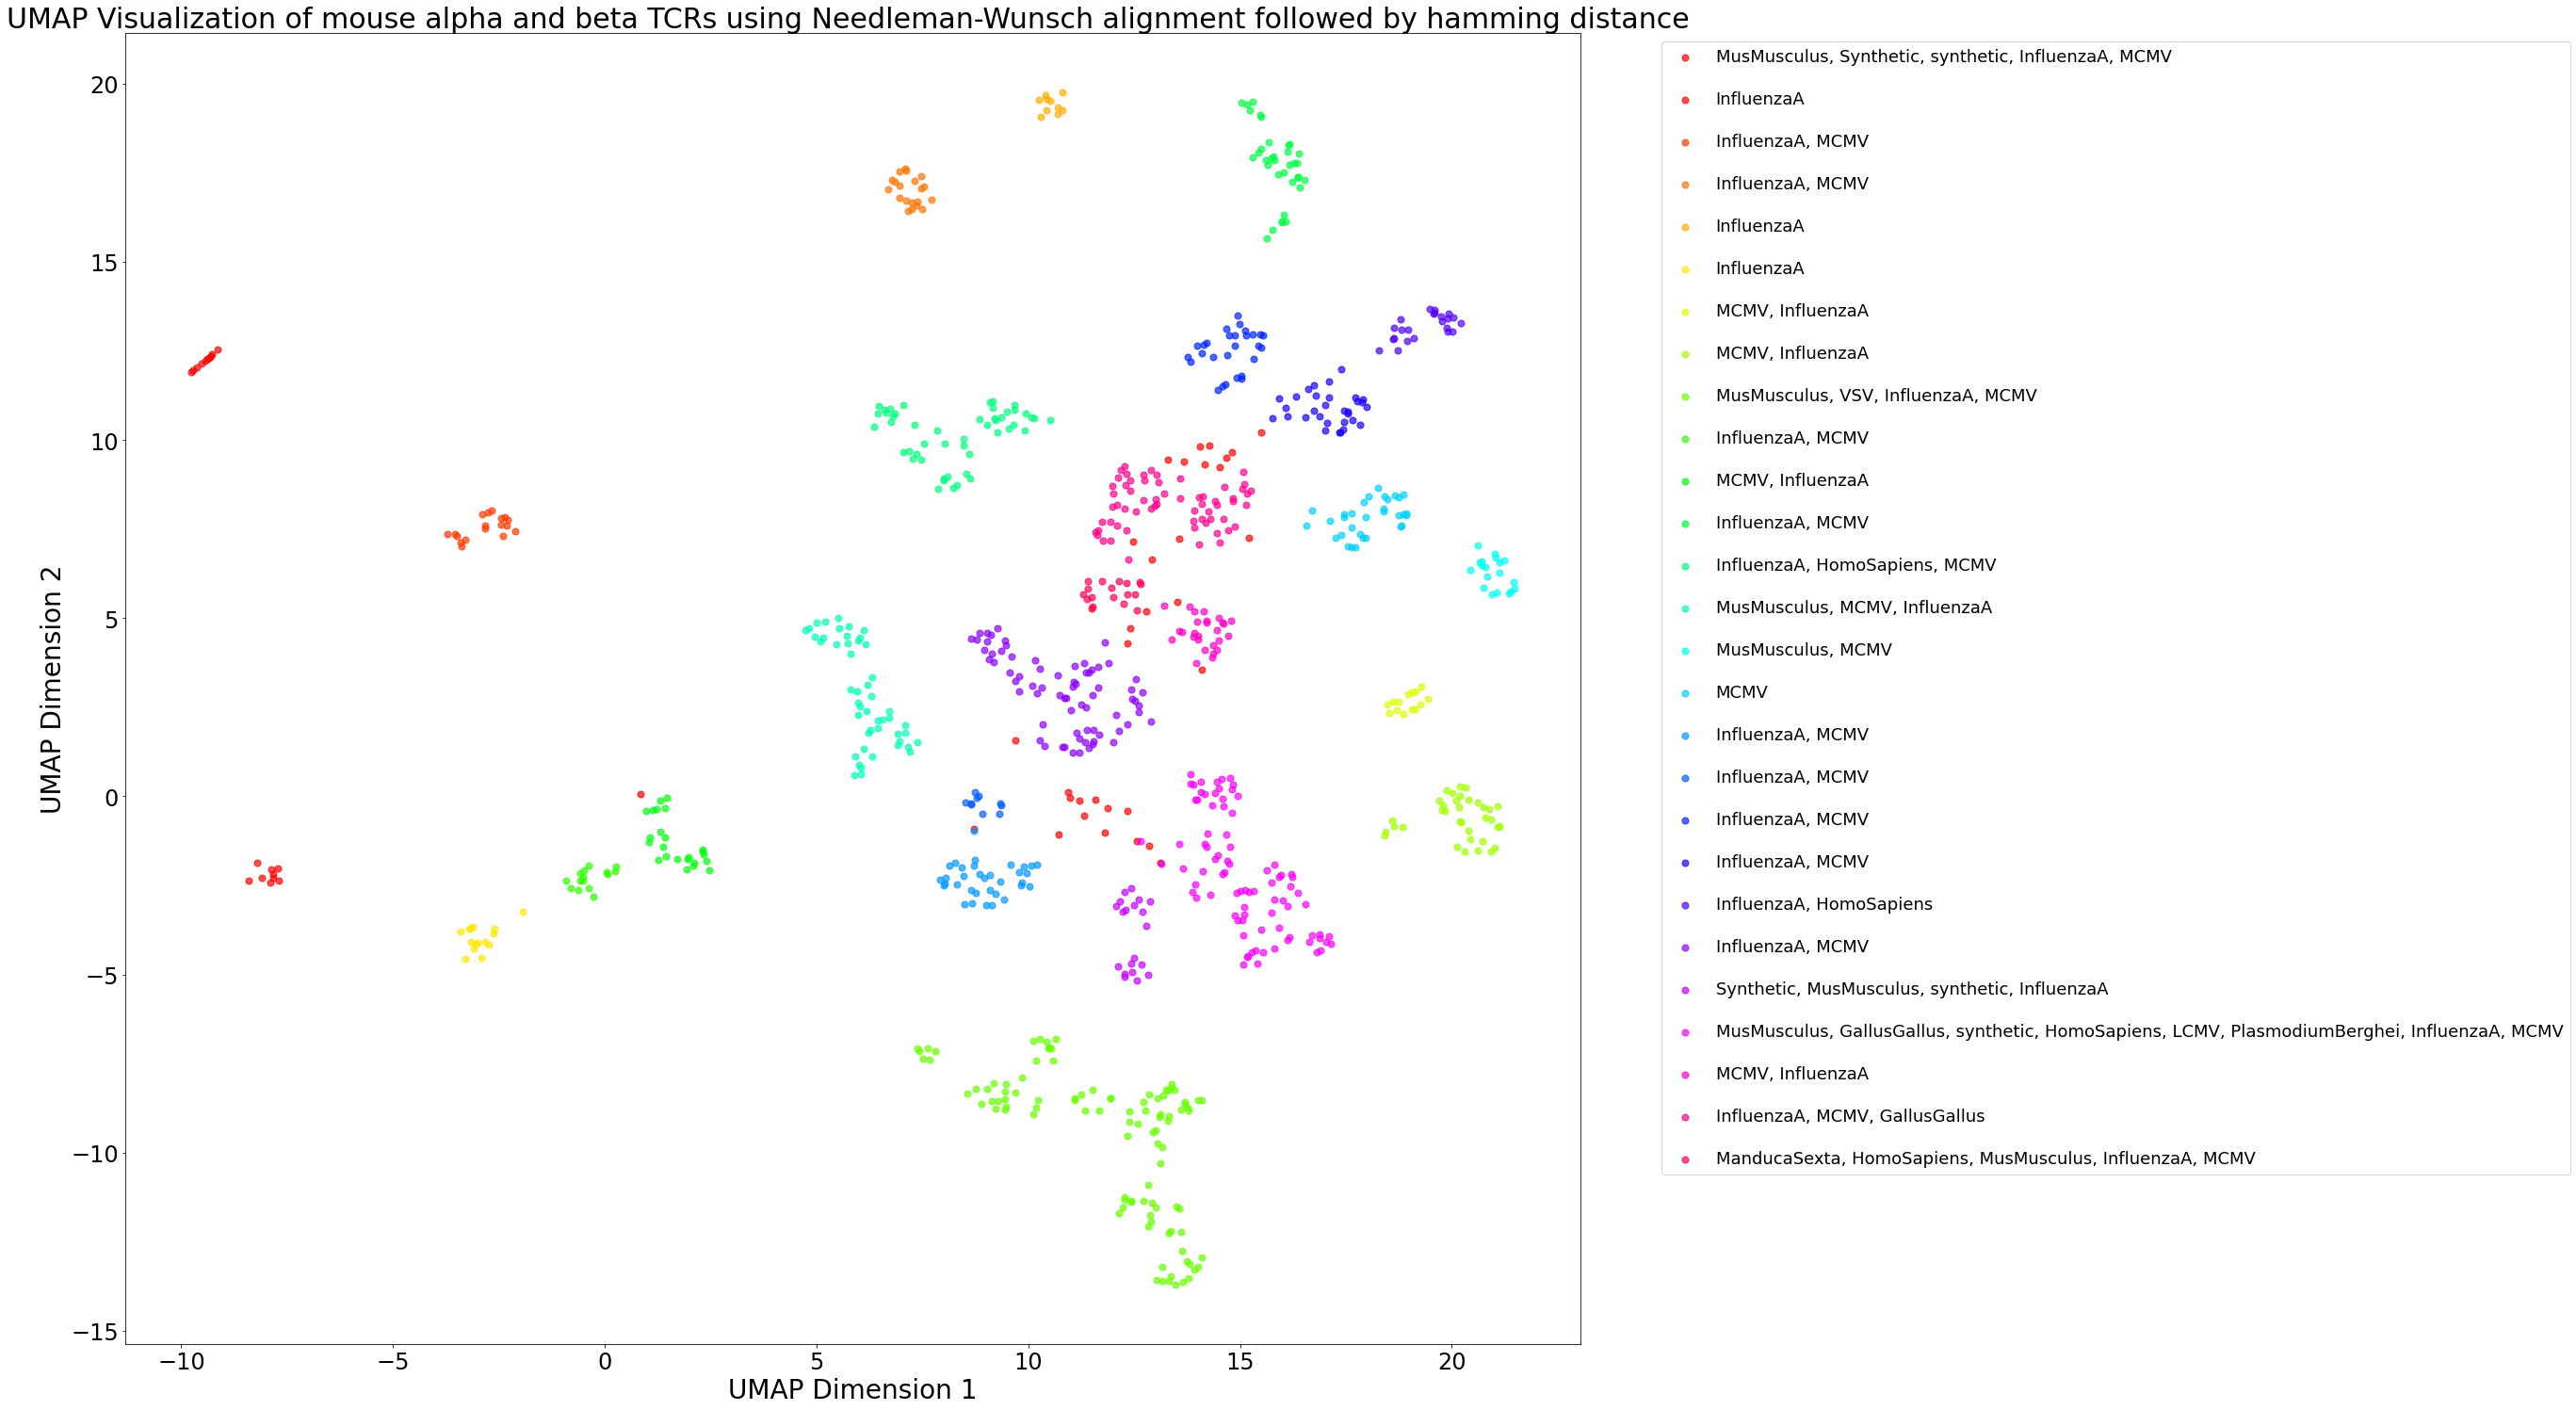

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of Needleman-Wunsch alignment score: 0.5377944707870483
Davies–Bouldin Index of Needleman-Wunsch alignment score: 1.4158477166814303


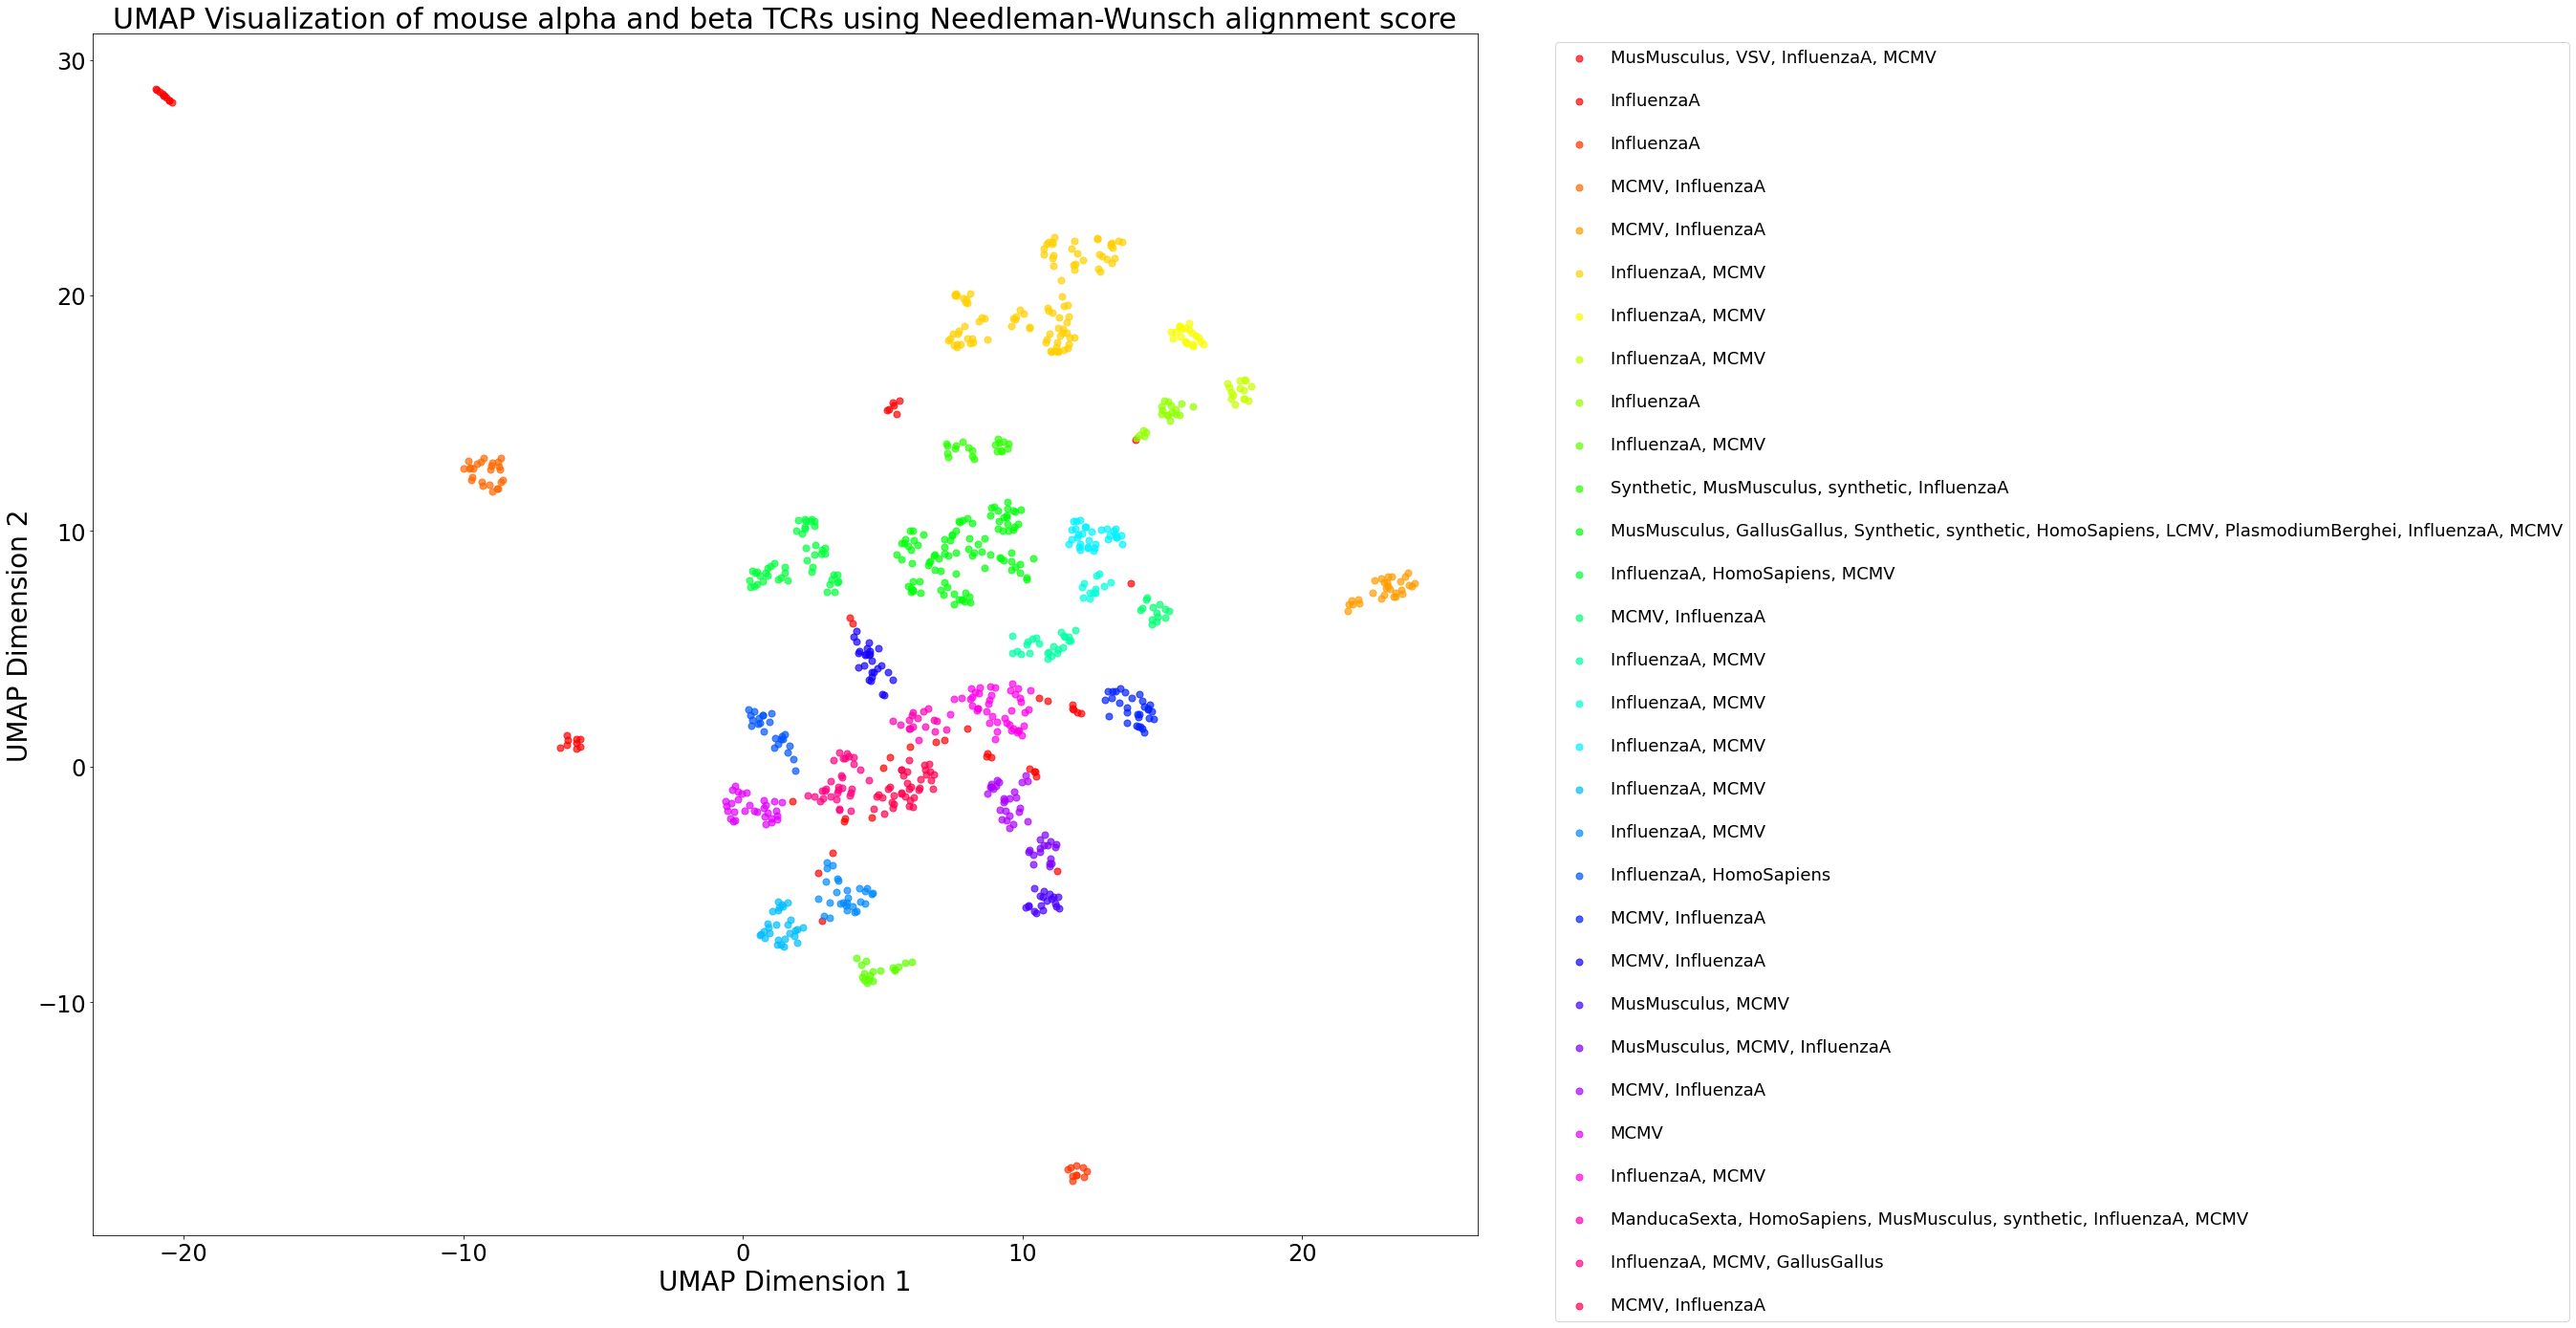

In [115]:
alpha_beta = [trm_alpha_beta_pwseqdist, trm_alpha_beta_hamming_metric, trm_alpha_beta_nw_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for alpha_beta, met_value in zip(alpha_beta, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(alpha_beta)

    labels = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=10).fit_predict(embedding)
    
    if np.array_equal(alpha_beta, trm_alpha_beta_pwseqdist):
        label_pwseqdist_alpha_beta = labels
    elif np.array_equal(alpha_beta, trm_alpha_beta_hamming_metric):
        label_hamming_metric_alpha_beta = labels
    else:
        label_nw_metric_alpha_beta = labels

    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    epitope_names = clone_3_m["EpitopeSpecies"]
    unique_clusters = sorted(set(labels))
    legend_labels = []

    plt.figure(figsize=(38, 21))
    for label in unique_clusters:
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)
        
        cluster_indices = labels == label
        epitope_cluster = epitope_names[cluster_indices]
        epitope_cluster_unique = epitope_cluster.unique()
        legend_labels.append(', '.join(epitope_cluster_unique))
        
    plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1,fontsize='18',labelspacing=1.5)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    plt.title(f'UMAP Visualization of mouse alpha and beta TCRs using {met_value}',fontsize = 30)
    plt.xlabel('UMAP Dimension 1',fontsize = 28)
    plt.ylabel('UMAP Dimension 2',fontsize = 28)
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


Use this below block of code to find out the epitopes in each cluster. Just replace the label name with one of the label parmters (label_pwseqdist_alpha,label_hamming_metric_beta etc..) and the clone with approprite clone for each TCRs data frame (alpha, beta or alpha and beta)

In [121]:
# epitope_names = clone_3_m["epitope"]
# unique_clusters = sorted(set(label_pwseqdist_alpha_beta))
# for cluster_label in unique_clusters:
#     cluster_indices = label_pwseqdist_alpha_beta == cluster_label
#     epitope_cluster = epitope_names[cluster_indices]
#     epitope_cluster_unique = epitope_cluster.unique()
#     print(f"Cluster {cluster_label}: {', '.join(epitope_cluster_unique)}")

# Human Data Cleaning and Mesuring the distance.

In [58]:
dfh = dfh.dropna()

In [59]:
dfh.isnull().values.any()

False

In [60]:
dfh_alpha = dfh[dfh['Gene'] == 'TRA']
dfh_beta= dfh[dfh['Gene'] == 'TRB']

In [61]:
dfh_alpha.reset_index(drop=True, inplace=True)
dfh_beta.reset_index(drop=True, inplace=True)

In [62]:
len(dfh_beta)

6596

# Measure the distance for alpha and beta dataframes (Human):

In [63]:
dfh_alpha_distance = dfh_alpha.drop(columns=['Gene','Species','MHCclass','Score'])
dfh_beta_distance = dfh_beta.drop(columns=['Gene','Species','MHCclass','Score'])
dfh_alpha_distance = dfh_alpha_distance.dropna()
dfh_beta_distance = dfh_beta_distance.dropna()

In [64]:
dfh_alpha_distance.isnull().values.any()

False

In [65]:
dfh_beta_distance.isnull().values.any()

False

In [66]:
num_duplicated_rows = dfh_alpha_distance.duplicated().sum()
num_duplicated_rows

361

In [67]:
num_duplicated_rows = dfh_beta_distance.duplicated().sum()
num_duplicated_rows

1351

In [68]:
dfh_alpha_distance = dfh_alpha_distance.rename(columns={'CDR3': 'cdr3_a_aa', 'V': 'v_a_gene', 'J': 'j_a_gene','Epitope': 'epitope'})
dfh_beta_distance = dfh_beta_distance.rename(columns={'CDR3': 'cdr3_b_aa', 'V': 'v_b_gene', 'J': 'j_b_gene','Epitope': 'epitope'})

In [69]:
dfh_alpha_distance = dfh_alpha_distance.groupby(dfh_alpha_distance.columns.tolist()).size().reset_index().rename(columns={0:'count'})
len(dfh_alpha_distance)

2419

In [70]:
dfh_beta_distance = dfh_beta_distance.groupby(dfh_beta_distance.columns.tolist()).size().reset_index().rename(columns={0:'count'})
len(dfh_beta_distance)

5245

# Distance betwen alpha chains (human)

In [71]:
tr_human_alpha_pwseqdist = TCRrep(cell_df = dfh_alpha_distance, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

trh_alpha_pwseqdist= tr_human_alpha_pwseqdist.pw_alpha
trh_alpha_pwseqdist

array([[  0, 162, 163, ..., 182, 171, 157],
       [162,   0,  92, ..., 160, 156,  98],
       [163,  92,   0, ..., 160, 176,  63],
       ...,
       [182, 160, 160, ...,   0, 141, 133],
       [171, 156, 176, ..., 141,   0, 158],
       [157,  98,  63, ..., 133, 158,   0]], dtype=int16)

In [72]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric, this distance include alpha chains that has complexID=0
metrics = [pw.metrics.nw_hamming_metric, pw.metrics.nw_metric]

for metric in metrics:
    tr = TCRrep(cell_df = dfh_alpha_distance, 
                organism = 'human', 
                chains = ['alpha'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')

    metrics_a = {
        "cdr3_a_aa" : metric ,
        "pmhc_a_aa" : metric ,
        "cdr2_a_aa" : metric ,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric ,
        "pmhc_b_aa" : metric ,
        "cdr2_b_aa" : metric ,
        "cdr1_b_aa" : metric  }

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }

    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    if metric == pw.metrics.nw_hamming_metric:
        trh_alpha_hamming_metric = tr.pw_alpha
    else:
        trh_alpha_nw_metric= tr.pw_alpha

# Distance between beta chains (human)

In [73]:
tr_human_beta_pwseqdist = TCRrep(cell_df = dfh_beta_distance, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

trh_beta_pwseqdist = tr_human_beta_pwseqdist.pw_beta
trh_beta_pwseqdist

array([[  0, 170, 159, ..., 151, 141, 140],
       [170,   0, 127, ..., 148, 174, 160],
       [159, 127,   0, ..., 140, 157, 153],
       ...,
       [151, 148, 140, ...,   0, 121,  97],
       [141, 174, 157, ..., 121,   0, 122],
       [140, 160, 153, ...,  97, 122,   0]], dtype=int16)

In [74]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric, this distance include beta chains that has complexID = 0
metrics = [pw.metrics.nw_hamming_metric, pw.metrics.nw_metric]

for metric in metrics:
    tr = TCRrep(cell_df = dfh_beta_distance, 
                organism = 'human', 
                chains = ['beta'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')

    metrics_a = {
        "cdr3_a_aa" : metric ,
        "pmhc_a_aa" : metric ,
        "cdr2_a_aa" : metric ,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric ,
        "pmhc_b_aa" : metric ,
        "cdr2_b_aa" : metric ,
        "cdr1_b_aa" : metric  }

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }

    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    if metric == pw.metrics.nw_hamming_metric:
        trh_beta_hamming_metric = tr.pw_beta
    else:
        trh_beta_nw_metric= tr.pw_beta

# Distance between alpha and beta chains (human) "Moving complex.ID 0"

In [75]:
dfh_zero_alpha_complexID = dfh_alpha_distance[dfh_alpha_distance['ComplexID'] == 0]

In [76]:
len(dfh_zero_alpha_complexID)

478

In [77]:
dfh_zero_beta_complexID = dfh_beta_distance[dfh_beta_distance['ComplexID'] == 0]

In [78]:
len(dfh_zero_beta_complexID)

3279

In [79]:
dfh_nonzero_alpha = dfh_alpha_distance[dfh_alpha_distance['ComplexID'] != 0]

In [80]:
dfh_nonzero_beta = dfh_beta_distance[dfh_beta_distance['ComplexID'] != 0]

In [81]:
len(dfh_nonzero_alpha)

1941

In [82]:
len(dfh_nonzero_beta)

1966

In [83]:
merged_dfh_nonzero = pd.merge(dfh_nonzero_alpha, dfh_nonzero_beta, on='ComplexID', how='inner')

In [84]:
len(merged_dfh_nonzero)

1868

In [85]:
#merged_dfh_nonzero

In [86]:
merged_dfh_nonzero = merged_dfh_nonzero[['ComplexID','cdr3_a_aa','v_a_gene','j_a_gene','cdr3_b_aa','v_b_gene','j_b_gene','epitope_x','EpitopeSpecies_x']]
merged_dfh_nonzero = merged_dfh_nonzero.groupby(merged_dfh_nonzero.columns.tolist()).size().reset_index().rename(columns={0:'count'})
merged_dfh_nonzero = merged_dfh_nonzero.rename(columns={'epitope_x':'epitope','EpitopeSpecies_x':'EpitopeSpecies'})

Calculate the distance.

In [87]:
tr_human_alpha_beta_pwseqdist = TCRrep(cell_df = merged_dfh_nonzero, 
            organism = 'human', 
            chains = ['alpha','beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

trh_beta_pwseqdist_1 = tr_human_alpha_beta_pwseqdist.pw_beta
trh_alpah_pwseqdist_1 = tr_human_alpha_beta_pwseqdist.pw_alpha
trh_alpha_beta_pwseqdist = trh_beta_pwseqdist_1 + trh_alpah_pwseqdist_1
trh_alpha_beta_pwseqdist

array([[  0, 177, 289, ..., 352, 391, 326],
       [177,   0, 310, ..., 322, 331, 297],
       [289, 310,   0, ..., 266, 297, 254],
       ...,
       [352, 322, 266, ...,   0, 262, 230],
       [391, 331, 297, ..., 262,   0, 280],
       [326, 297, 254, ..., 230, 280,   0]], dtype=int16)

In [88]:
#pw.metrics.nw_hamming_metric and pw.metrics.nw_metric, this distance include alpha and beta chains.
metrics = [pw.metrics.nw_hamming_metric, pw.metrics.nw_metric]

for metric in metrics:
    tr = TCRrep(cell_df = merged_dfh_nonzero, 
                organism = 'human', 
                chains = ['alpha','beta'], 
                use_defaults=False,
                compute_distances = False,
                cpus = 1,
                db_file = 'alphabeta_gammadelta_db.tsv')

    metrics_a = {
        "cdr3_a_aa" : metric ,
        "pmhc_a_aa" : metric ,
        "cdr2_a_aa" : metric ,
        "cdr1_a_aa" : metric }

    metrics_b = {
        "cdr3_b_aa" : metric ,
        "pmhc_b_aa" : metric ,
        "cdr2_b_aa" : metric ,
        "cdr1_b_aa" : metric  }

    weights_a = { 
        "cdr3_a_aa" : 1,
        "pmhc_a_aa" : 1,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : 1,
        "pmhc_b_aa" : 1,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': False},
        'pmhc_a_aa' : {
            'use_numba': False},
        'cdr2_a_aa' : {
            'use_numba': False},
        'cdr1_a_aa' : {
            'use_numba': False}
        }
    kargs_b = {  
        'cdr3_b_aa' : 
            {'use_numba': False},
        'pmhc_b_aa' : {
            'use_numba': False},
        'cdr2_b_aa' : {
            'use_numba': False},
        'cdr1_b_aa' : {
            'use_numba': False}
        }

    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    if metric == pw.metrics.nw_hamming_metric:
        trh_alpha_hamming_metric_1 = tr.pw_alpha
        trh_beta_hamming_metric_1 = tr.pw_beta
        trh_alpha_beta_hamming_metric = trh_alpha_hamming_metric_1 + trh_beta_hamming_metric_1
    else:
        trh_alpha_nw_metric_1 = tr.pw_alpha
        trh_beta_nw_metric_1 = tr.pw_beta
        trh_alpha_beta_nw_metric = trh_alpha_nw_metric_1 + trh_beta_nw_metric_1

# Clustering:

In [89]:
clone_1_h = tr_human_alpha_pwseqdist.clone_df
clone_2_h = tr_human_beta_pwseqdist.clone_df
clone_3_h = tr_human_alpha_beta_pwseqdist.clone_df

The below block of code is used just to create a hierarchical cluster for each of the pairwise distance metrics used before 
for alpha, beta, and both alpha and beta. Using this code will generate an HTML file showing the cluster interactively.
to use this code you need to pass the previous distance metric and previous clones "clone_1_m, clone_2_m, clone_3_m" to output
the cluster as html file. You can uncomment this code and use it after passing the previously mentioned variables correctly.

In [ ]:
# pairwise_metrics = [trh_alpha_pwseqdist,trh_alpha_hamming_metric,trh_alpha_nw_metric,
#                    trh_beta_pwseqdist, trh_beta_hamming_metric, trh_beta_nw_metric,
#                    trh_alpha_beta_pwseqdist, trh_alpha_beta_nw_metric, trh_alpha_beta_hamming_metric]
# clone_2_h['NLVPMVATV'] = ['NLVPMVATV' if x == 'NLVPMVATV' else 'X' for x in clone_2_h.epitope]
# res, Z= hcluster_diff(clone_2_h, trh_beta_nw_metric, x_cols = ['NLVPMVATV'], count_col = 'count')
# res_summary = member_summ(res_df = res, clone_df = clone_2_h, addl_cols=['epitope'])
# res_detailed = pd.concat([res, res_summary], axis = 1)
# html = plot_hclust_props(Z,
#                          title=f'Clustering TCRs human beta chains using nw_metric',
#                          res=res_detailed,
#                          tooltip_cols=['cdr3_b_aa','v_b_gene', 'j_b_gene','epitope'],
#                          alpha=0.00001, colors = ['blue','green'],
#                          alpha_col='pvalue')
# with open('human_beta_clustering_nw_metric.html', 'w') as fh:
#     fh.write(html)

# Clustering using UMAP/ Human alpha chains

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.28805574774742126
Davies–Bouldin Index of PwSeqDist: 0.4054045110427196


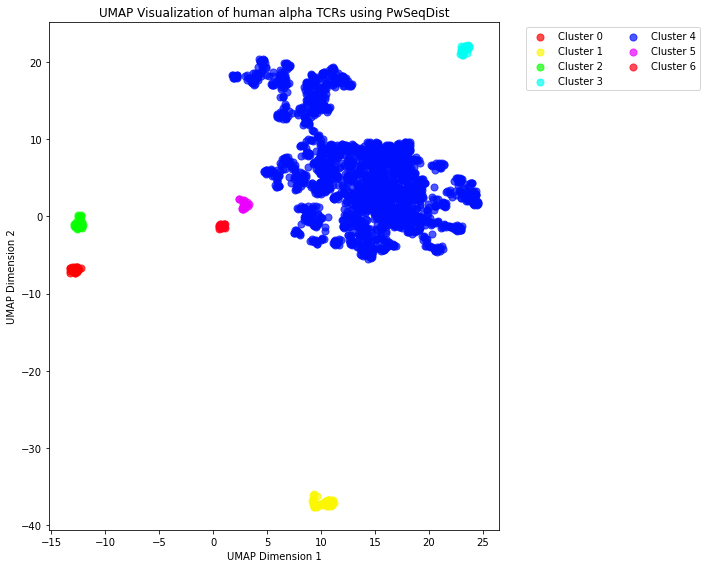

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.7007842063903809
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 0.36422666811686916


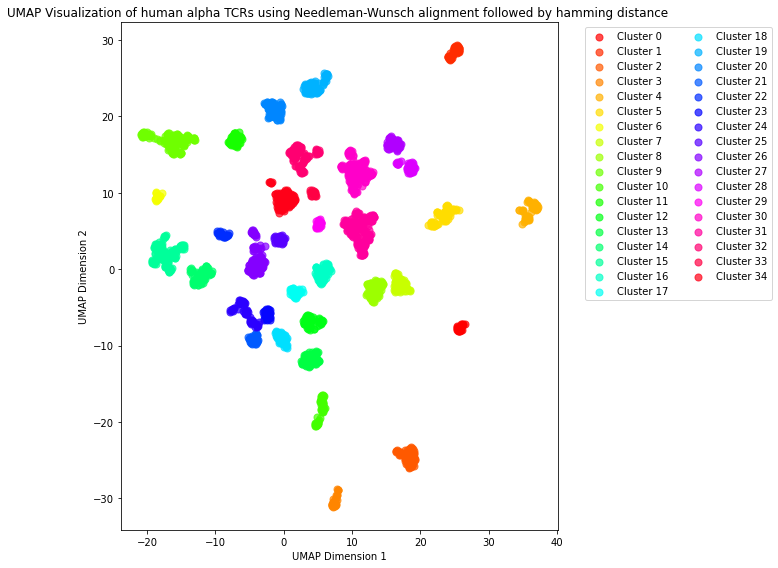

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment score: 0.7098804116249084
Davies–Bouldin Index of Needleman-Wunsch alignment score: 0.5014414424870905


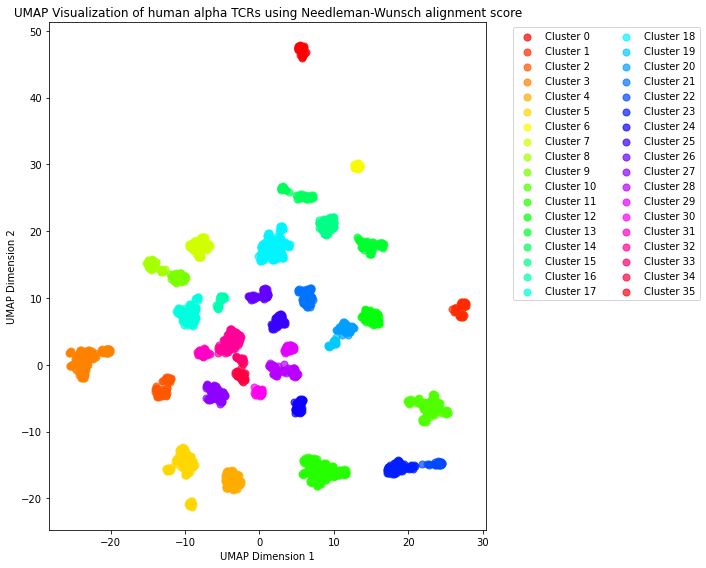

In [140]:
alpha = [trh_alpha_pwseqdist,trh_alpha_hamming_metric,trh_alpha_nw_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for x, met_value in zip(alpha, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(x)

    labels = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=20).fit_predict(embedding)
    
    if np.array_equal(x, trh_alpha_pwseqdist):
        label_pwseqdist_alpha_h = labels
    elif np.array_equal(x, trh_alpha_hamming_metric):
        label_hamming_metric_alpha_h = labels
    else:
        label_nw_metric_alpha_h = labels

    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    plt.figure(figsize=(10, 8))
    for label in range(num_labels):
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'UMAP Visualization of human alpha TCRs using {met_value}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


# Clustering using UMAP/ Human beta chains

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.14578251540660858
Davies–Bouldin Index of PwSeqDist: 1.8186824214816022


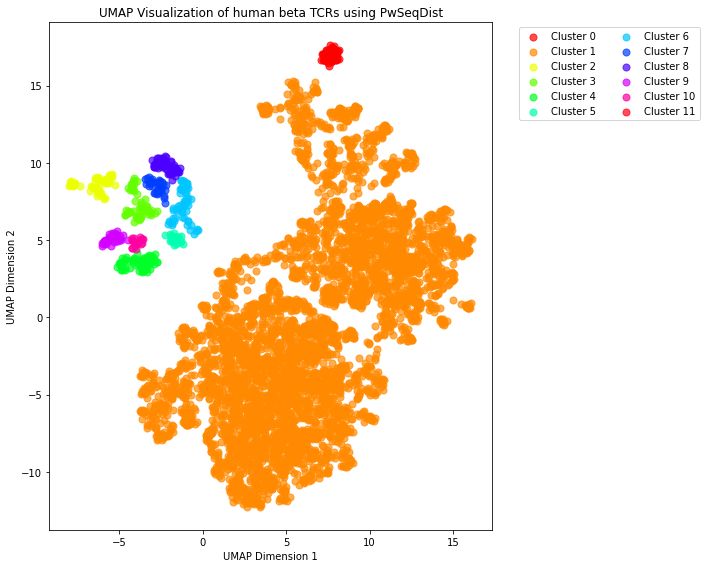

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.5478652119636536
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 1.1395606001769223


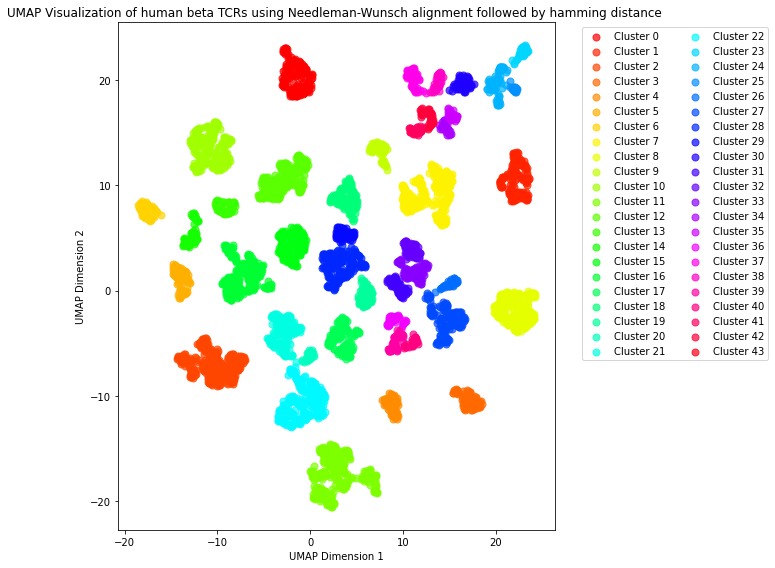

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Score of Needleman-Wunsch alignment score: 0.5535674095153809
Davies–Bouldin Index of Needleman-Wunsch alignment score: 1.700987546391519


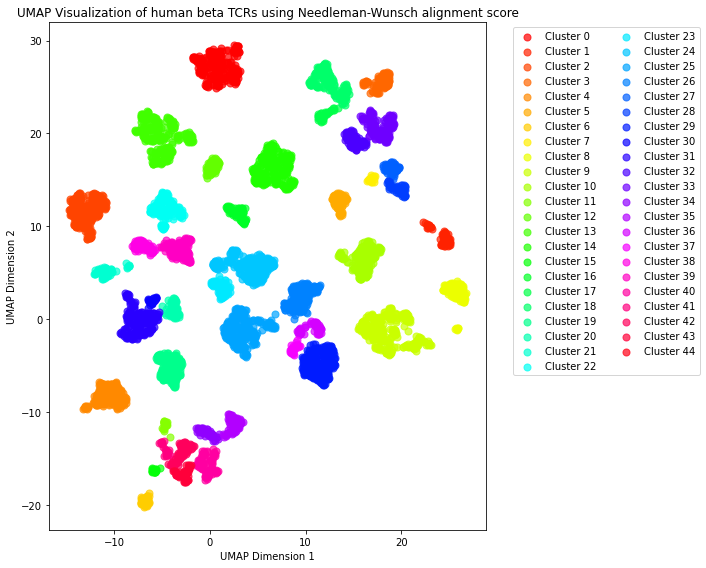

In [129]:
beta = [trh_beta_pwseqdist,trh_beta_hamming_metric,trh_beta_nw_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for x, met_value in zip(beta, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(x)

    labels = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=20).fit_predict(embedding)
    
    if np.array_equal(x, trh_beta_pwseqdist):
        label_pwseqdist_beta_h = labels
    elif np.array_equal(x, trh_beta_hamming_metric):
        label_hamming_metric_beta_h = labels
    else:
        label_nw_metric_beta_h = labels

    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    plt.figure(figsize=(10, 8))
    for label in range(num_labels):
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'UMAP Visualization of human beta TCRs using {met_value}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


# Clustering using UMAP/ Human alpha and beta chains

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of PwSeqDist: 0.8381180167198181
Davies–Bouldin Index of PwSeqDist: 0.1320949599010704


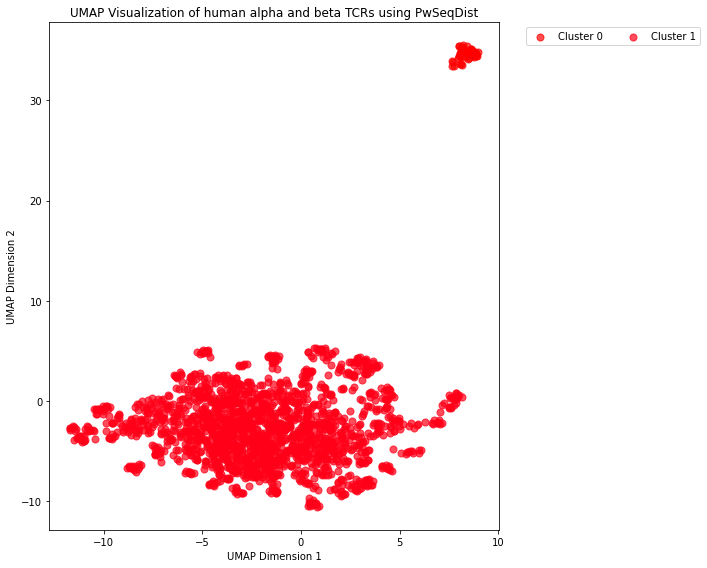

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of Needleman-Wunsch alignment followed by hamming distance : 0.29575231671333313
Davies–Bouldin Index of Needleman-Wunsch alignment followed by hamming distance : 1.1889056396779443


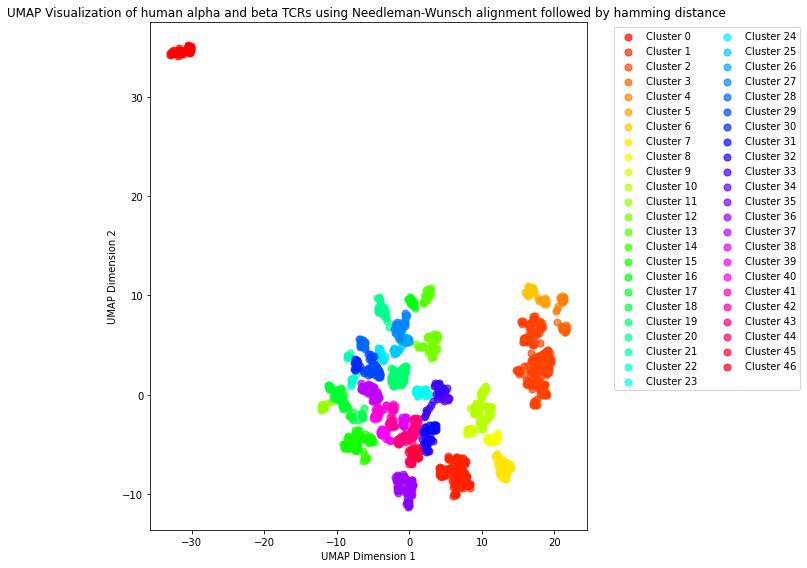

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score of Needleman-Wunsch alignment score: 0.3521614074707031
Davies–Bouldin Index of Needleman-Wunsch alignment score: 1.602516222217949


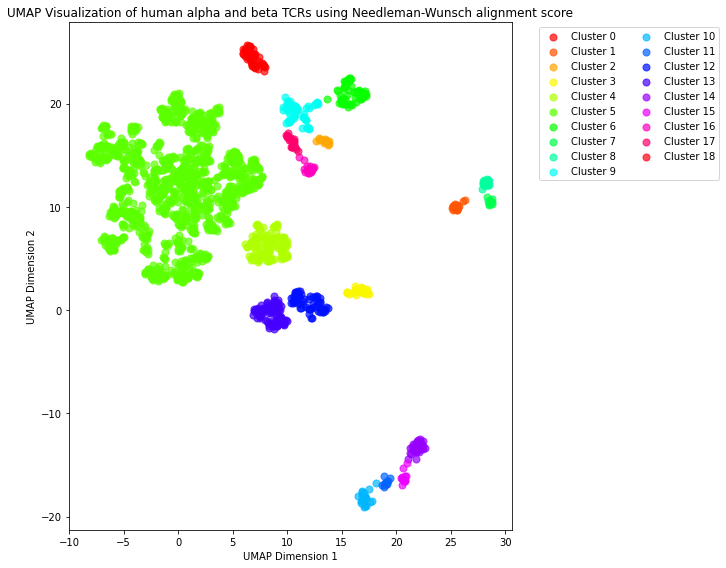

In [128]:
alpha_beta = [trh_alpha_beta_pwseqdist, trh_alpha_beta_nw_metric, trh_alpha_beta_hamming_metric]
met = ['PwSeqDist', 'Needleman-Wunsch alignment followed by hamming distance ', 'Needleman-Wunsch alignment score']

for x, met_value in zip(alpha_beta, met):
    embedding = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2, random_state=42).fit_transform(x)

    labels = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=10).fit_predict(embedding)
    
    if np.array_equal(x, trh_alpha_beta_pwseqdist):
        label_pwseqdist_alpha_beta_h = labels
    elif np.array_equal(x, trh_alpha_beta_nw_metric):
        label_hamming_metric_alpha_beta_h = labels
    else:
        label_nw_metric_alpha_beta_h = labels

    num_labels = len(np.unique(labels))

    color_map = plt.cm.get_cmap('hsv', num_labels)

    plt.figure(figsize=(10, 8))
    for label in range(num_labels):
        clustered = (labels == label)
        plt.scatter(embedding[clustered, 0],
                    embedding[clustered, 1],
                    color=color_map(label),
                    label=f'Cluster {label}',
                    s=50,
                    alpha=0.7)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    
    plt.title(f'UMAP Visualization of human alpha and beta TCRs using {met_value}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.tight_layout()
    
    # Compute silhouette score
    silhouette = silhouette_score(embedding, labels)
    print(f"Silhouette Score of {met_value}: {silhouette}")
    
    # Compute Davies–Bouldin index
    davies_bouldin = davies_bouldin_score(embedding, labels)
    print(f"Davies–Bouldin Index of {met_value}: {davies_bouldin}")
    
    plt.show()


Use this below block of code to find out the epitopes in each cluster. Just replace the label name with one of the label parmters (label_pwseqdist_alpha,label_hamming_metric_beta etc..) and the clone with approprite clone for each TCRs data frame (alpha, beta or alpha and beta)

In [141]:
# epitope_names = clone_2_h["epitope"]
# unique_clusters = sorted(set(label_hamming_metric_beta_h))
# for cluster_label in unique_clusters:
#     cluster_indices = label_hamming_metric_beta_h == cluster_label
#     epitope_cluster = epitope_names[cluster_indices]
#     epitope_cluster_unique = epitope_cluster.unique()
#     print(f"Cluster {cluster_label}: {', '.join(epitope_cluster_unique)}")

# Classification usin SVM multi calss classification.

# Mouse TCRs Classification/SVM

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.403315  0.174696   0.244160  0.172399
2  0.430939  0.176889   0.261564  0.167580
3  0.422222  0.156179   0.275900  0.159902
4  0.416667  0.141880   0.226514  0.128551
5  0.394444  0.143966   0.289257  0.147957


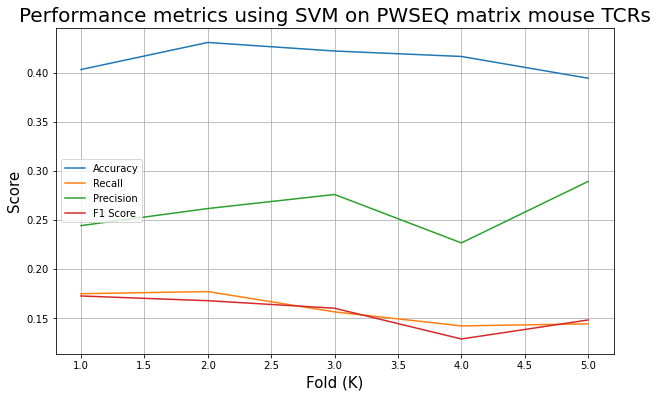

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.546961  0.239352   0.325676  0.237993
2  0.563536  0.247144   0.371721  0.264455
3  0.544444  0.200132   0.310795  0.214651
4  0.577778  0.259085   0.352663  0.279407
5  0.527778  0.247563   0.414539  0.267722


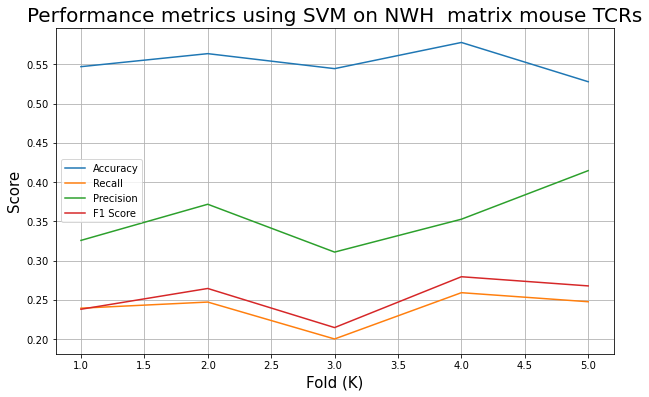

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.397790  0.115528   0.222491  0.117023
2  0.392265  0.127937   0.242133  0.129261
3  0.416667  0.146447   0.266993  0.150312
4  0.405556  0.131934   0.234160  0.133314
5  0.394444  0.093459   0.293340  0.101945


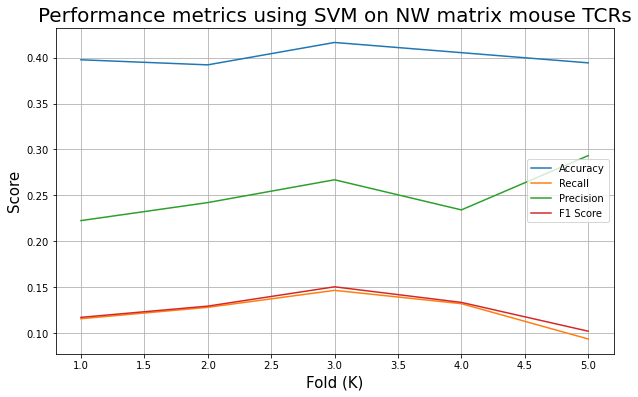

In [126]:
distance_values = [trm_alpha_beta_pwseqdist, trm_alpha_beta_hamming_metric, trm_alpha_beta_nw_metric]
distance_names = ['PWSEQ', 'NWH ', 'NW']

for i, distance in enumerate(distance_values):
    # Convert distance matrix to kernel matrix
    kernel_matrix = np.exp(-distance) 
    
    X = pd.DataFrame(kernel_matrix)
    Y = clone_3_m['epitope'].copy()
    
    metrics_cv_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1'])
    
    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    kfolds.get_n_splits(X)
    
    for j, (train_ind, test_ind) in enumerate(kfolds.split(X, Y), 1):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]
        model = OneVsRestClassifier(SVC(kernel='precomputed', probability=True))
        # Use fit_predict with precomputed kernel
        gram_train = X_train.dot(X_train.T)
        model.fit(gram_train, Y_train)
        gram_test = X_test.dot(X_train.T)
        preds_labels = model.predict(gram_test)

        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro')
        recall_fold = recall_score(Y_test, preds_labels, average='macro')
        f1_fold = f1_score(Y_test, preds_labels, average='macro')

        metrics_cv_df.loc[j] = [accuracy_fold, recall_fold, precision_fold, f1_fold]
        
    print(metrics_cv_df)
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_cv_df.index, metrics_cv_df['Accuracy'], label='Accuracy')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Recall'], label='Recall')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Precision'], label='Precision')
    plt.plot(metrics_cv_df.index, metrics_cv_df['F1'], label='F1 Score')
    plt.xlabel('Fold (K)',fontsize=15)
    plt.ylabel('Score',fontsize=15)
    plt.title('Performance metrics using SVM on {} matrix mouse TCRs'.format(distance_names[i]),fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()


# Human TCRs Classification /SVM

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.377005  0.139253   0.163261  0.141815
2  0.374332  0.122934   0.119405  0.108204
3  0.390374  0.114596   0.139389  0.114431
4  0.388740  0.151553   0.173130  0.148722
5  0.378016  0.129725   0.140324  0.126076


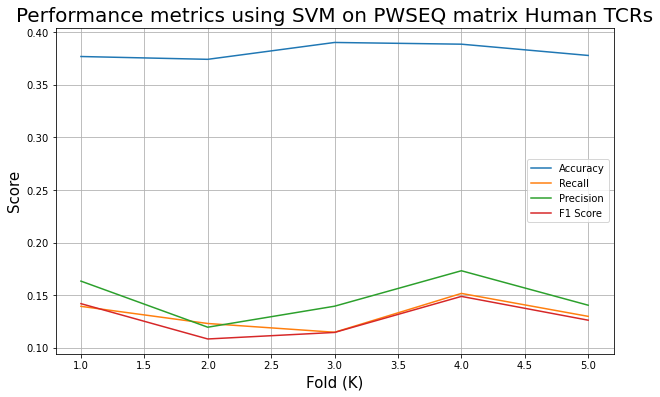

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.422460  0.154802   0.176380  0.153678
2  0.422460  0.143431   0.161696  0.145899
3  0.454545  0.155417   0.191305  0.155847
4  0.439678  0.182756   0.220793  0.186248
5  0.436997  0.154975   0.175737  0.156055


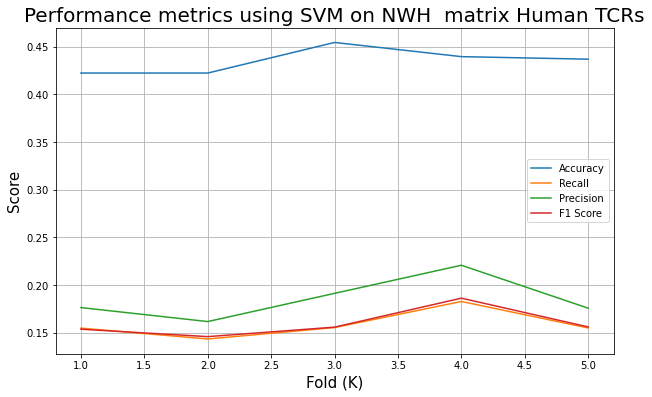

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

   Accuracy    Recall  Precision        F1
1  0.374332  0.143184   0.166385  0.142795
2  0.374332  0.123799   0.122007  0.110273
3  0.387701  0.114089   0.136286  0.112776
4  0.386059  0.152991   0.177389  0.151353
5  0.375335  0.128336   0.144498  0.129082


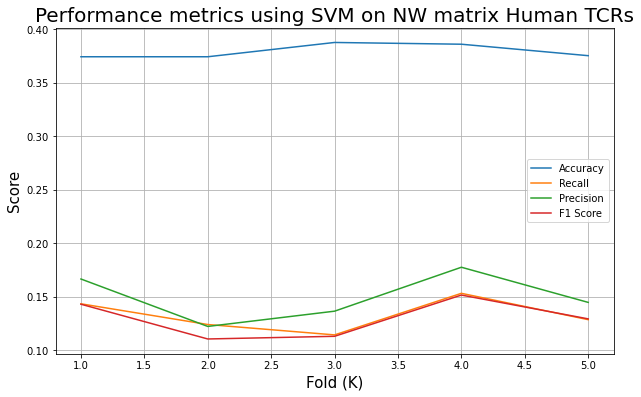

In [118]:
distance_values = [trh_alpha_beta_pwseqdist, trh_alpha_beta_hamming_metric, trh_alpha_beta_nw_metric]
distance_names = ['PWSEQ', 'NWH ', 'NW']

for i, distance in enumerate(distance_values):
    # Convert distance matrix to kernel matrix
    kernel_matrix = np.exp(-distance)
    
    X = pd.DataFrame(kernel_matrix)
    Y = clone_3_h['epitope'].copy()
    
    metrics_cv_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1'])
    
    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    kfolds.get_n_splits(X)
    
    for j, (train_ind, test_ind) in enumerate(kfolds.split(X, Y), 1):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]
        model = OneVsRestClassifier(SVC(kernel='precomputed', probability=True))
        # Use fit_predict with precomputed kernel
        gram_train = X_train.dot(X_train.T)
        model.fit(gram_train, Y_train)
        gram_test = X_test.dot(X_train.T)
        preds_labels = model.predict(gram_test)

        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro')
        recall_fold = recall_score(Y_test, preds_labels, average='macro')
        f1_fold = f1_score(Y_test, preds_labels, average='macro')

        metrics_cv_df.loc[j] = [accuracy_fold, recall_fold, precision_fold, f1_fold]
        
    print(metrics_cv_df)
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_cv_df.index, metrics_cv_df['Accuracy'], label='Accuracy')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Recall'], label='Recall')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Precision'], label='Precision')
    plt.plot(metrics_cv_df.index, metrics_cv_df['F1'], label='F1 Score')
    plt.xlabel('Fold (K)',fontsize=15)
    plt.ylabel('Score',fontsize=15)
    plt.title('Performance metrics using SVM on {} matrix Human TCRs'.format(distance_names[i]),fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

# Classification Using KNN

# Mouse TCRs Classification /KNN 

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\2114447649.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.745856  0.359896  0.340727  0.340817
1  0.756906   0.33483  0.336797   0.33502
2  0.755556  0.388496  0.361597   0.35825
3  0.744444  0.438288  0.427704  0.427021
4  0.738889  0.427271  0.422615  0.416262


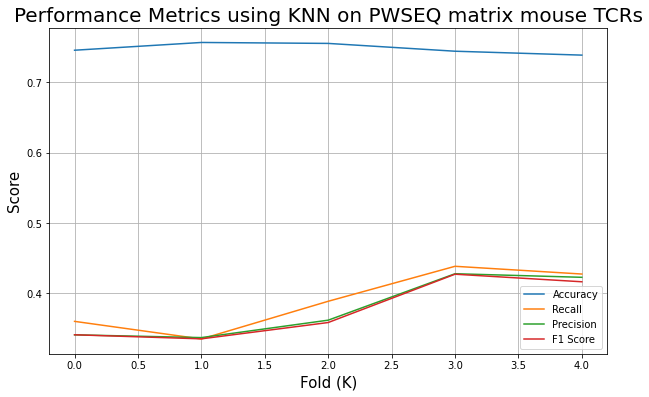

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\2114447649.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.729282  0.342616  0.314462  0.319673
1  0.745856  0.316875  0.313773  0.308206
2  0.727778  0.316941  0.295313  0.291835
3  0.727778  0.431206  0.403068  0.407441
4  0.722222  0.472674  0.476476  0.464426


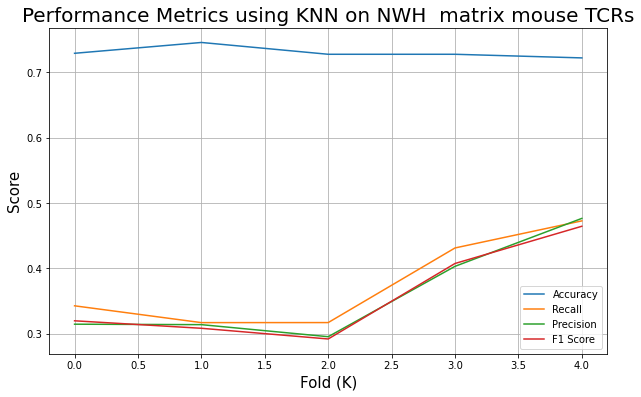

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\2114447649.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.740331  0.357686  0.346096   0.34637
1  0.723757  0.308986   0.30023  0.298364
2  0.733333  0.379216  0.353016  0.351362
3  0.733333   0.43615   0.42559   0.42525
4  0.727778  0.473468  0.481463  0.466687


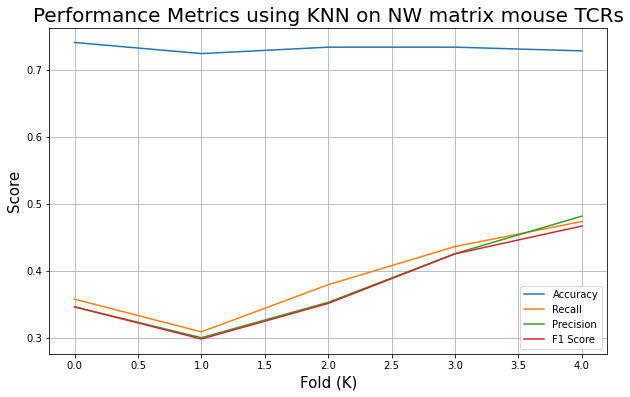

In [139]:
distance_values = [trm_alpha_beta_pwseqdist, trm_alpha_beta_hamming_metric, trm_alpha_beta_nw_metric]
distance_names = ['PWSEQ', 'NWH ', 'NW']

for i, distance in enumerate(distance_values):
    X = pd.DataFrame(distance)
    Y = clone_3_m['epitope'].copy()
    metrics_cv_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1'])

    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    kfolds.get_n_splits(X)

    for train_ind, test_ind in kfolds.split(X, Y):
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]
        model = KNeighborsClassifier(n_neighbors=20, metric='precomputed', weights='distance')
        model.fit(X_train, Y_train)

        preds_labels = model.predict(X_test)
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro')
        recall_fold = recall_score(Y_test, preds_labels, average='macro')
        f1_fold = f1_score(Y_test, preds_labels, average='macro')
        metrics_cv_df = metrics_cv_df.append(pd.Series({'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold,'F1': f1_fold}), ignore_index=True)
    print(metrics_cv_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_cv_df.index, metrics_cv_df['Accuracy'], label='Accuracy')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Recall'], label='Recall')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Precision'], label='Precision')
    plt.plot(metrics_cv_df.index, metrics_cv_df['F1'], label='F1 Score')
    plt.xlabel('Fold (K)',fontsize=15)
    plt.ylabel('Score',fontsize=15)
    plt.title('Performance Metrics using KNN on {} matrix mouse TCRs'.format(distance_names[i]),fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

# Human TCRs Classification /KNN

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\1724734835.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.513369  0.169061  0.169764  0.163226
1  0.510695  0.174007  0.172286  0.168374
2  0.513369  0.164726  0.180812  0.160727
3  0.509383  0.195313  0.198609  0.188236
4  0.495979  0.147125  0.147564  0.143967


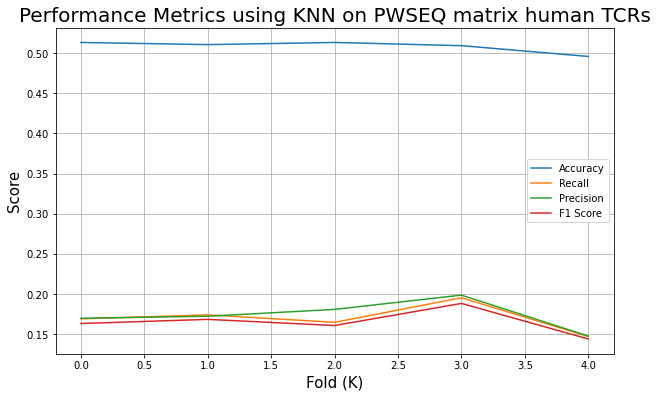

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\1724734835.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.513369  0.177229   0.17418  0.168834
1  0.508021  0.178456  0.173422  0.169846
2  0.529412  0.164402  0.174044  0.158269
3  0.525469  0.204182  0.197962  0.192097
4  0.485255  0.153092   0.14795  0.147565


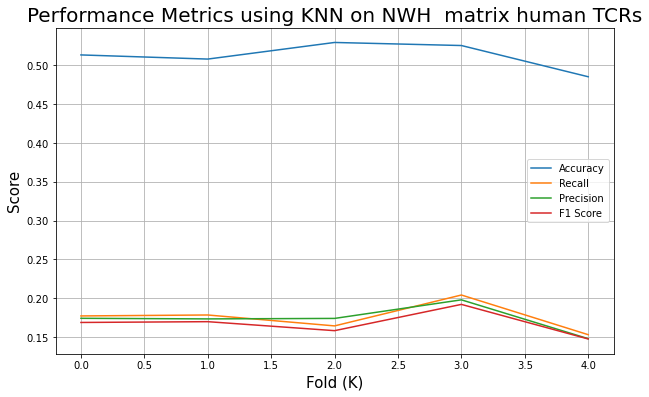

C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bayan Alsaghier\AppData\Local\Temp\ipykernel_26464\1724734835.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

   Accuracy    Recall Precision        F1
0  0.516043  0.176544  0.173458  0.168404
1   0.52139  0.179367  0.174796   0.17117
2  0.524064  0.157475  0.165498  0.150661
3  0.514745  0.195641  0.191197   0.18501
4  0.495979  0.147066  0.144429  0.142397


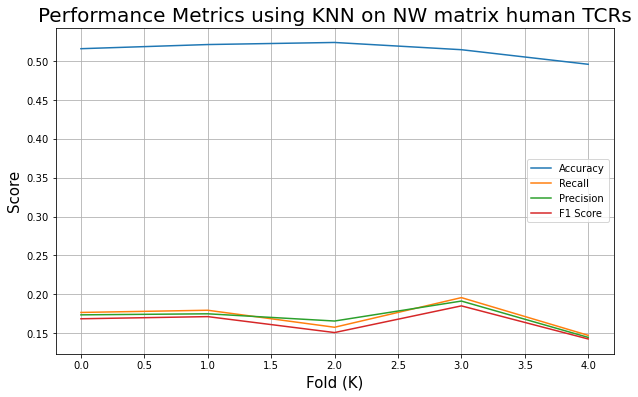

In [115]:
distance_values = [trh_alpha_beta_pwseqdist, trh_alpha_beta_hamming_metric, trh_alpha_beta_nw_metric]

for i, distance in enumerate(distance_values):
    X = pd.DataFrame(distance)
    Y = clone_3_h['epitope'].copy()
    metrics_cv_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1'])

    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    kfolds.get_n_splits(X)

    for train_ind, test_ind in kfolds.split(X, Y):
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]
        model = KNeighborsClassifier(n_neighbors=100, metric='precomputed', weights='distance')
        model.fit(X_train, Y_train)

        preds_labels = model.predict(X_test)
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro')
        recall_fold = recall_score(Y_test, preds_labels, average='macro')
        f1_fold = f1_score(Y_test, preds_labels, average='macro')
        metrics_cv_df = metrics_cv_df.append(pd.Series({'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold,'F1': f1_fold}), ignore_index=True)
    print(metrics_cv_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_cv_df.index, metrics_cv_df['Accuracy'], label='Accuracy')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Recall'], label='Recall')
    plt.plot(metrics_cv_df.index, metrics_cv_df['Precision'], label='Precision')
    plt.plot(metrics_cv_df.index, metrics_cv_df['F1'], label='F1 Score')
    plt.xlabel('Fold (K)',fontsize=15)
    plt.ylabel('Score',fontsize=15)
    plt.title('Performance Metrics using KNN on {} matrix human TCRs'.format(distance_names[i]),fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()
